In [1]:
import pandas as pd
import plotnine as p9


In [2]:
def json_array_to_values(json_array):
    json_array = json_array.replace("\\xa0", " ")
    json_array = eval(json_array)

    values = []
    for genre in json_array:
        values.append(genre["name"])

    return values


In [3]:
df_md = pd.read_csv("the-movies-dataset/movies_metadata.csv")
drop_columns = {
    "adult",
    "belongs_to_collection",
    "homepage",
    "imdb_id",
    "original_title",
    "overview",
    "poster_path",
    "status",
    "tagline",
    "video",
    "spoken_languages",
    "production_companies",
}

dropping = {
    "TV Movie",
    "Foreign",
}

movie_clusters = {
    "Adventure": ["Adventure", "Fantasy"], # OK
    "Horror": ["Horror", "Science Fiction"], # OK
    "Documentary": ["Documentary", "History", "War"],  # OK
    "Action": ["Action", "Thriller", "Mystery", "Crime", "Western"], # OK
    "Animation": ["Animation", "Music", "Family"], # OK
    "Comedy": ["Comedy", "Romance"],  # OK
    "Drama": ["Drama"],  # OK
}

# Let's assign the main genre to each movie
def assign_main_genre(genres, clusters=movie_clusters):
    genres = [genre for genre in genres if genre not in dropping and genre != ""]
    if len(genres) == 0:
        return None

    main_movie_genre = genres[0]

    for cluster, cluster_genres in clusters.items():
        if main_movie_genre in cluster_genres:
            return cluster

    return None

df_md.drop(drop_columns, axis=1, inplace=True)

# Convert the release_date column to year, month and day
df_md = df_md[df_md["release_date"].str.len() == 10]
df_md["release_date"] = pd.to_datetime(df_md["release_date"])
df_md["release_year"] = df_md["release_date"].dt.year
df_md["release_month"] = df_md["release_date"].dt.month
df_md["release_day"] = df_md["release_date"].dt.day
df_md["release_quarter"] = df_md["release_date"].dt.quarter
df_md["season"] = df_md["release_month"].apply(
    lambda x: "Winter"
    if x in [12, 1, 2]
    else ("Spring" if x in [3, 4, 5] else ("Summer" if x in [6, 7, 8] else "Fall"))
)
df_md.drop("release_date", axis=1, inplace=True)

# Select only movies released between 1980 and 2015
df_md = df_md[df_md["release_year"] >= 1980]
df_md = df_md[df_md["release_year"] <= 2015]

numeric_columns = [
    "id",
    "budget",
    "revenue",
    "runtime",
    "popularity",
    "vote_average",
    "vote_count",
    "release_year",
    "release_month",
    "release_day",
]

for column in numeric_columns:
    df_md[column] = pd.to_numeric(df_md[column], errors="coerce")

df_md.dropna(subset=numeric_columns, inplace=True)

# Convert the json columns to arrays
df_md["genres"] = df_md["genres"].apply(lambda x: json_array_to_values(x))
df_md["production_countries"] = df_md["production_countries"].apply(
    lambda x: json_array_to_values(x)
)

# Create a new column with the main genre and the genre count
df_md["main_genre"] = df_md["genres"].apply(lambda x: assign_main_genre(x, movie_clusters))
df_md.dropna(subset=["main_genre"], inplace=True)

df_md["genre_count"] = df_md["genres"].apply(lambda x: len(x))


/var/folders/s0/tqtx5tfn21b8rys89pkqht4m0000gn/T/ipykernel_14458/655634466.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


In [4]:
df_kw = pd.read_csv("the-movies-dataset/keywords.csv")

df_kw["id"] = pd.to_numeric(df_kw["id"], errors="coerce")
df_kw.dropna(subset=["id"], inplace=True)

df_kw["keywords"] = df_kw["keywords"].apply(lambda x: json_array_to_values(x))


In [5]:
df_main = pd.merge(df_md, df_kw, left_on="id", right_on="id", how="left")
df_main.head().transpose()


,0,1,2,3,4
budget,30000000,65000000,0,16000000,0
genres,"[Animation, Comedy, Family]","[Adventure, Fantasy, Family]","[Romance, Comedy]","[Comedy, Drama, Romance]",[Comedy]
id,862,8844,15602,31357,11862
original_language,en,en,en,en,en
popularity,21.946943,17.015539,11.7129,3.859495,8.387519
production_countries,[United States of America],[United States of America],[United States of America],[United States of America],[United States of America]
revenue,373554033.0,262797249.0,0.0,81452156.0,76578911.0
runtime,81.0,104.0,101.0,127.0,106.0
title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II
vote_average,7.7,6.9,6.5,6.1,5.7


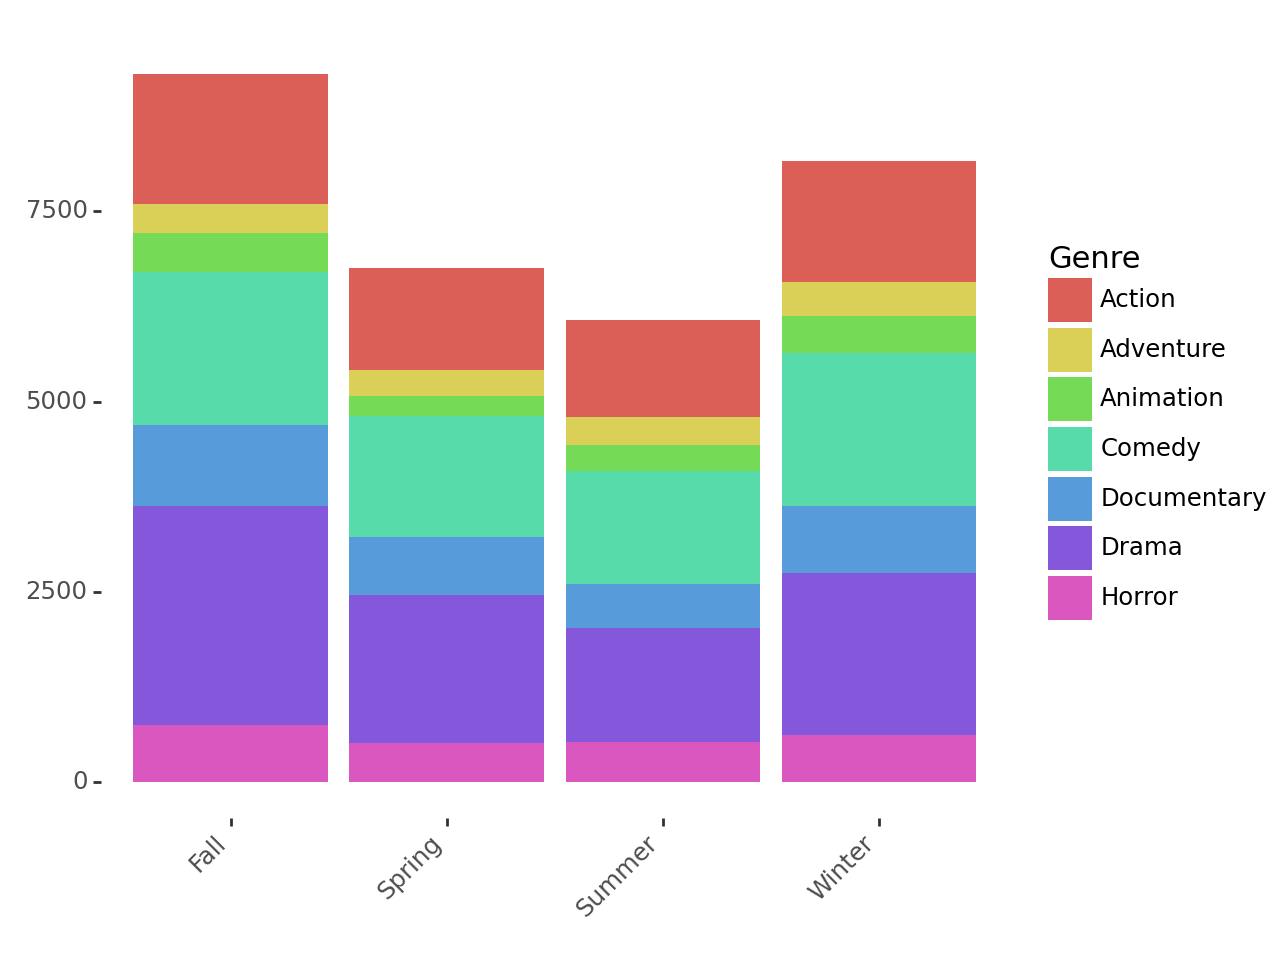

In [6]:
# Stacked bar chart with the number of movies per season and genre
# df_main["season"] = pd.Categorical(df_main["season"], ["Winter", "Spring", "Summer", "Fall"])
# df_main["main_genre"] = pd.Categorical(df_main["main_genre"], genres)

df_season_genre = (
    df_main.groupby(["season", "main_genre"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

# print(df_season_genre)

p = (
    p9.ggplot(df_season_genre, p9.aes(x="season", y="count", fill="main_genre"))
    + p9.geom_col(position="stack")
    + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))
    + p9.theme(panel_background=p9.element_blank())
    + p9.labs(fill="Genre")
    + p9.ylab("")
    + p9.xlab("")
    + p9.theme(panel_grid_major_y=p9.element_line(color="white", size=0.5))

    # + p9.geom_hline(yintercept=range(0, 10000, 1000), color="#ffffff", size=0.5)

)

p.draw()


/Users/oliver/ZHAW/subjects/infviz/infvis-poster/venv/lib/python3.11/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_fill_cmap could not recognise parameter `low`
/Users/oliver/ZHAW/subjects/infviz/infvis-poster/venv/lib/python3.11/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_fill_cmap could not recognise parameter `high`


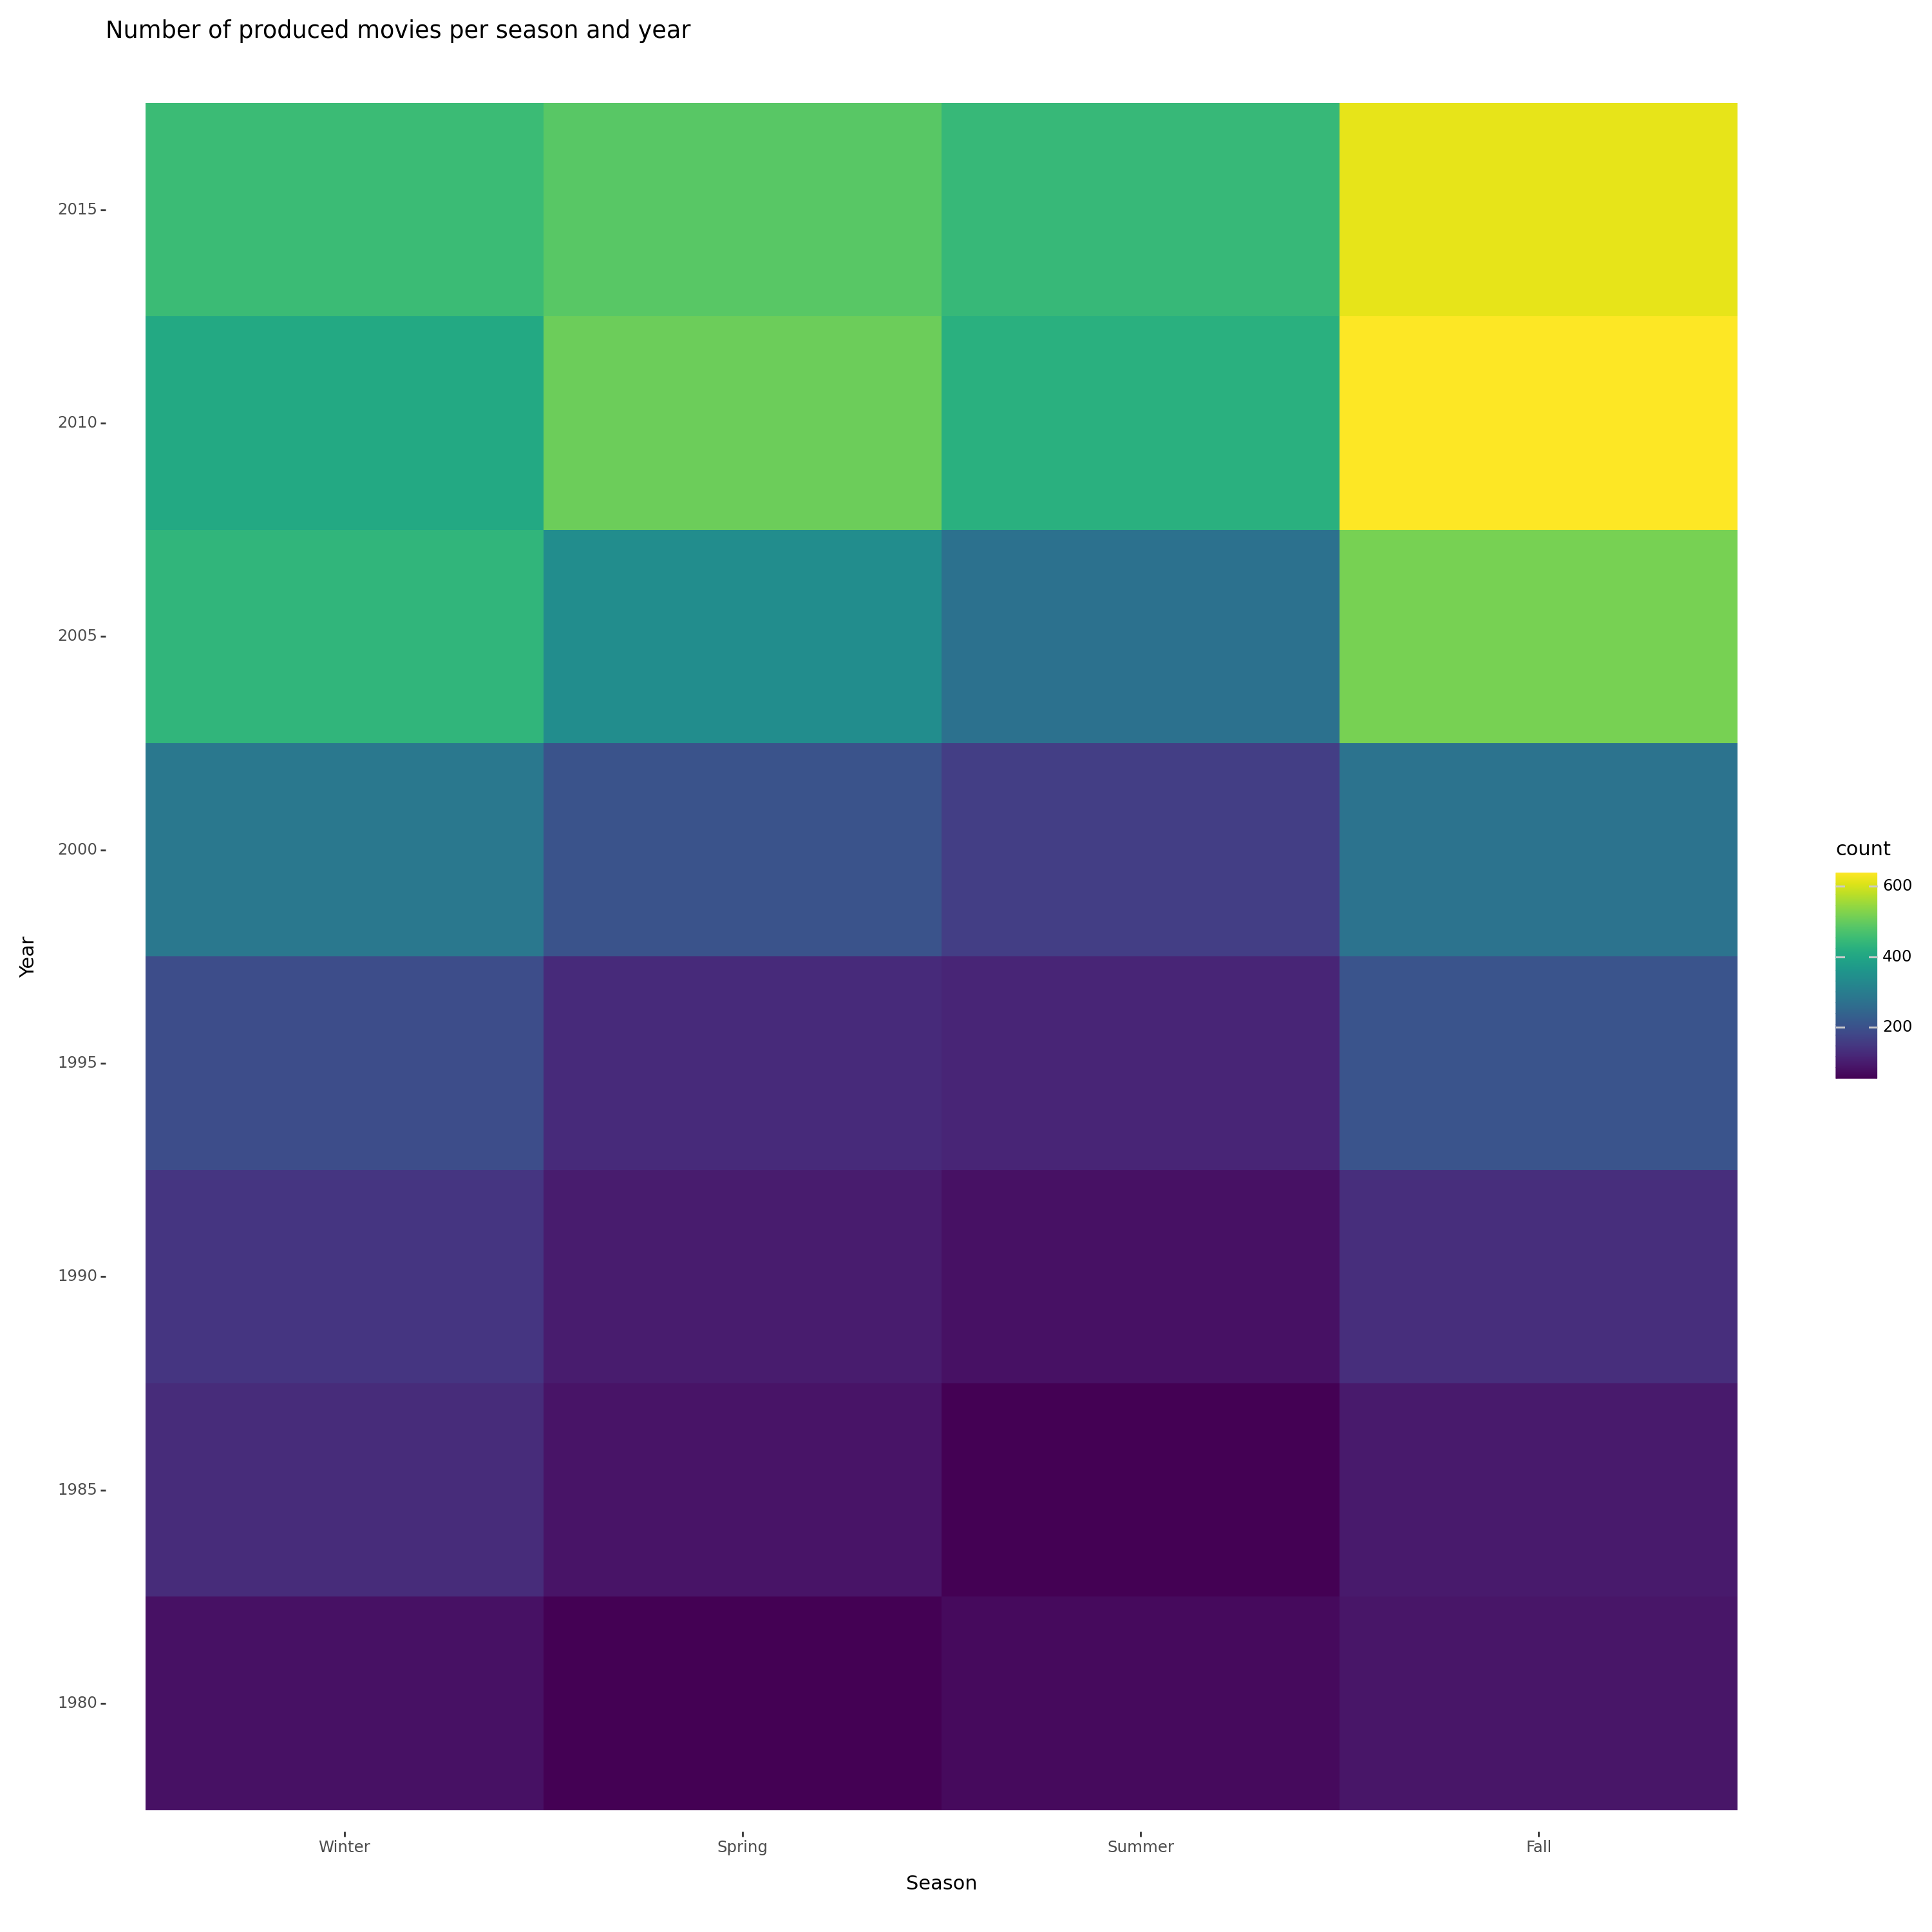

In [7]:
# Number of produced movies per season and year
df_season_count = (
    df_main.groupby(["season", "release_year"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

# reorder the seasons
df_season_count["season"] = pd.Categorical(
    df_season_count["season"], ["Winter", "Spring", "Summer", "Fall", "oli"]
)

# group by 5 years
df_season_count["release_year"] = df_season_count["release_year"].apply(
    lambda x: x - x % 5
)

# make the release_year a categorical variable
df_season_count["release_year"] = pd.Categorical(
    df_season_count["release_year"], sorted(df_season_count["release_year"].unique())
)

p = (
    p9.ggplot(
        df_season_count, p9.aes("season", "release_year", fill="count")
    )
    + p9.geom_tile()
    + p9.labs(x="Season", y="Year", title="Number of produced movies per season and year")
    + p9.scale_fill_continuous(low="#ffffff", high="#1f77b4")
    # + p9.scale_x_continuous(breaks=range(1, 13))
    # + p9.scale_y_continuous(breaks=range(1970, 2016, 5))
    + p9.theme(
        figure_size=(15, 15),
        panel_background=p9.element_rect(fill="white"),
        # panel_grid_major=p9.element_line(color="#dfdfdf", size=5),
    )

)


# p = (
#     p9.ggplot(
#         df_season_count, p9.aes("season", "release_year", fill="count")
#     )
#     + p9.geom_tile()
#     + p9.labs(x="Season", y="Year", title="Number of produced movies per season and year")
#     + p9.scale_fill_continuous(low="#ffffff", high="#1f77b4")
#     # + p9.scale_x_continuous(breaks=range(1, 13))
#     # + p9.scale_y_continuous(breaks=range(1970, 2016, 5))
#     + p9.theme(
#         figure_size=(15, 15),
#         panel_background=p9.element_rect(fill="white"),
#         panel_grid_major=p9.element_line(color="#dfdfdf", size=5),
#     )
# )
p.draw()


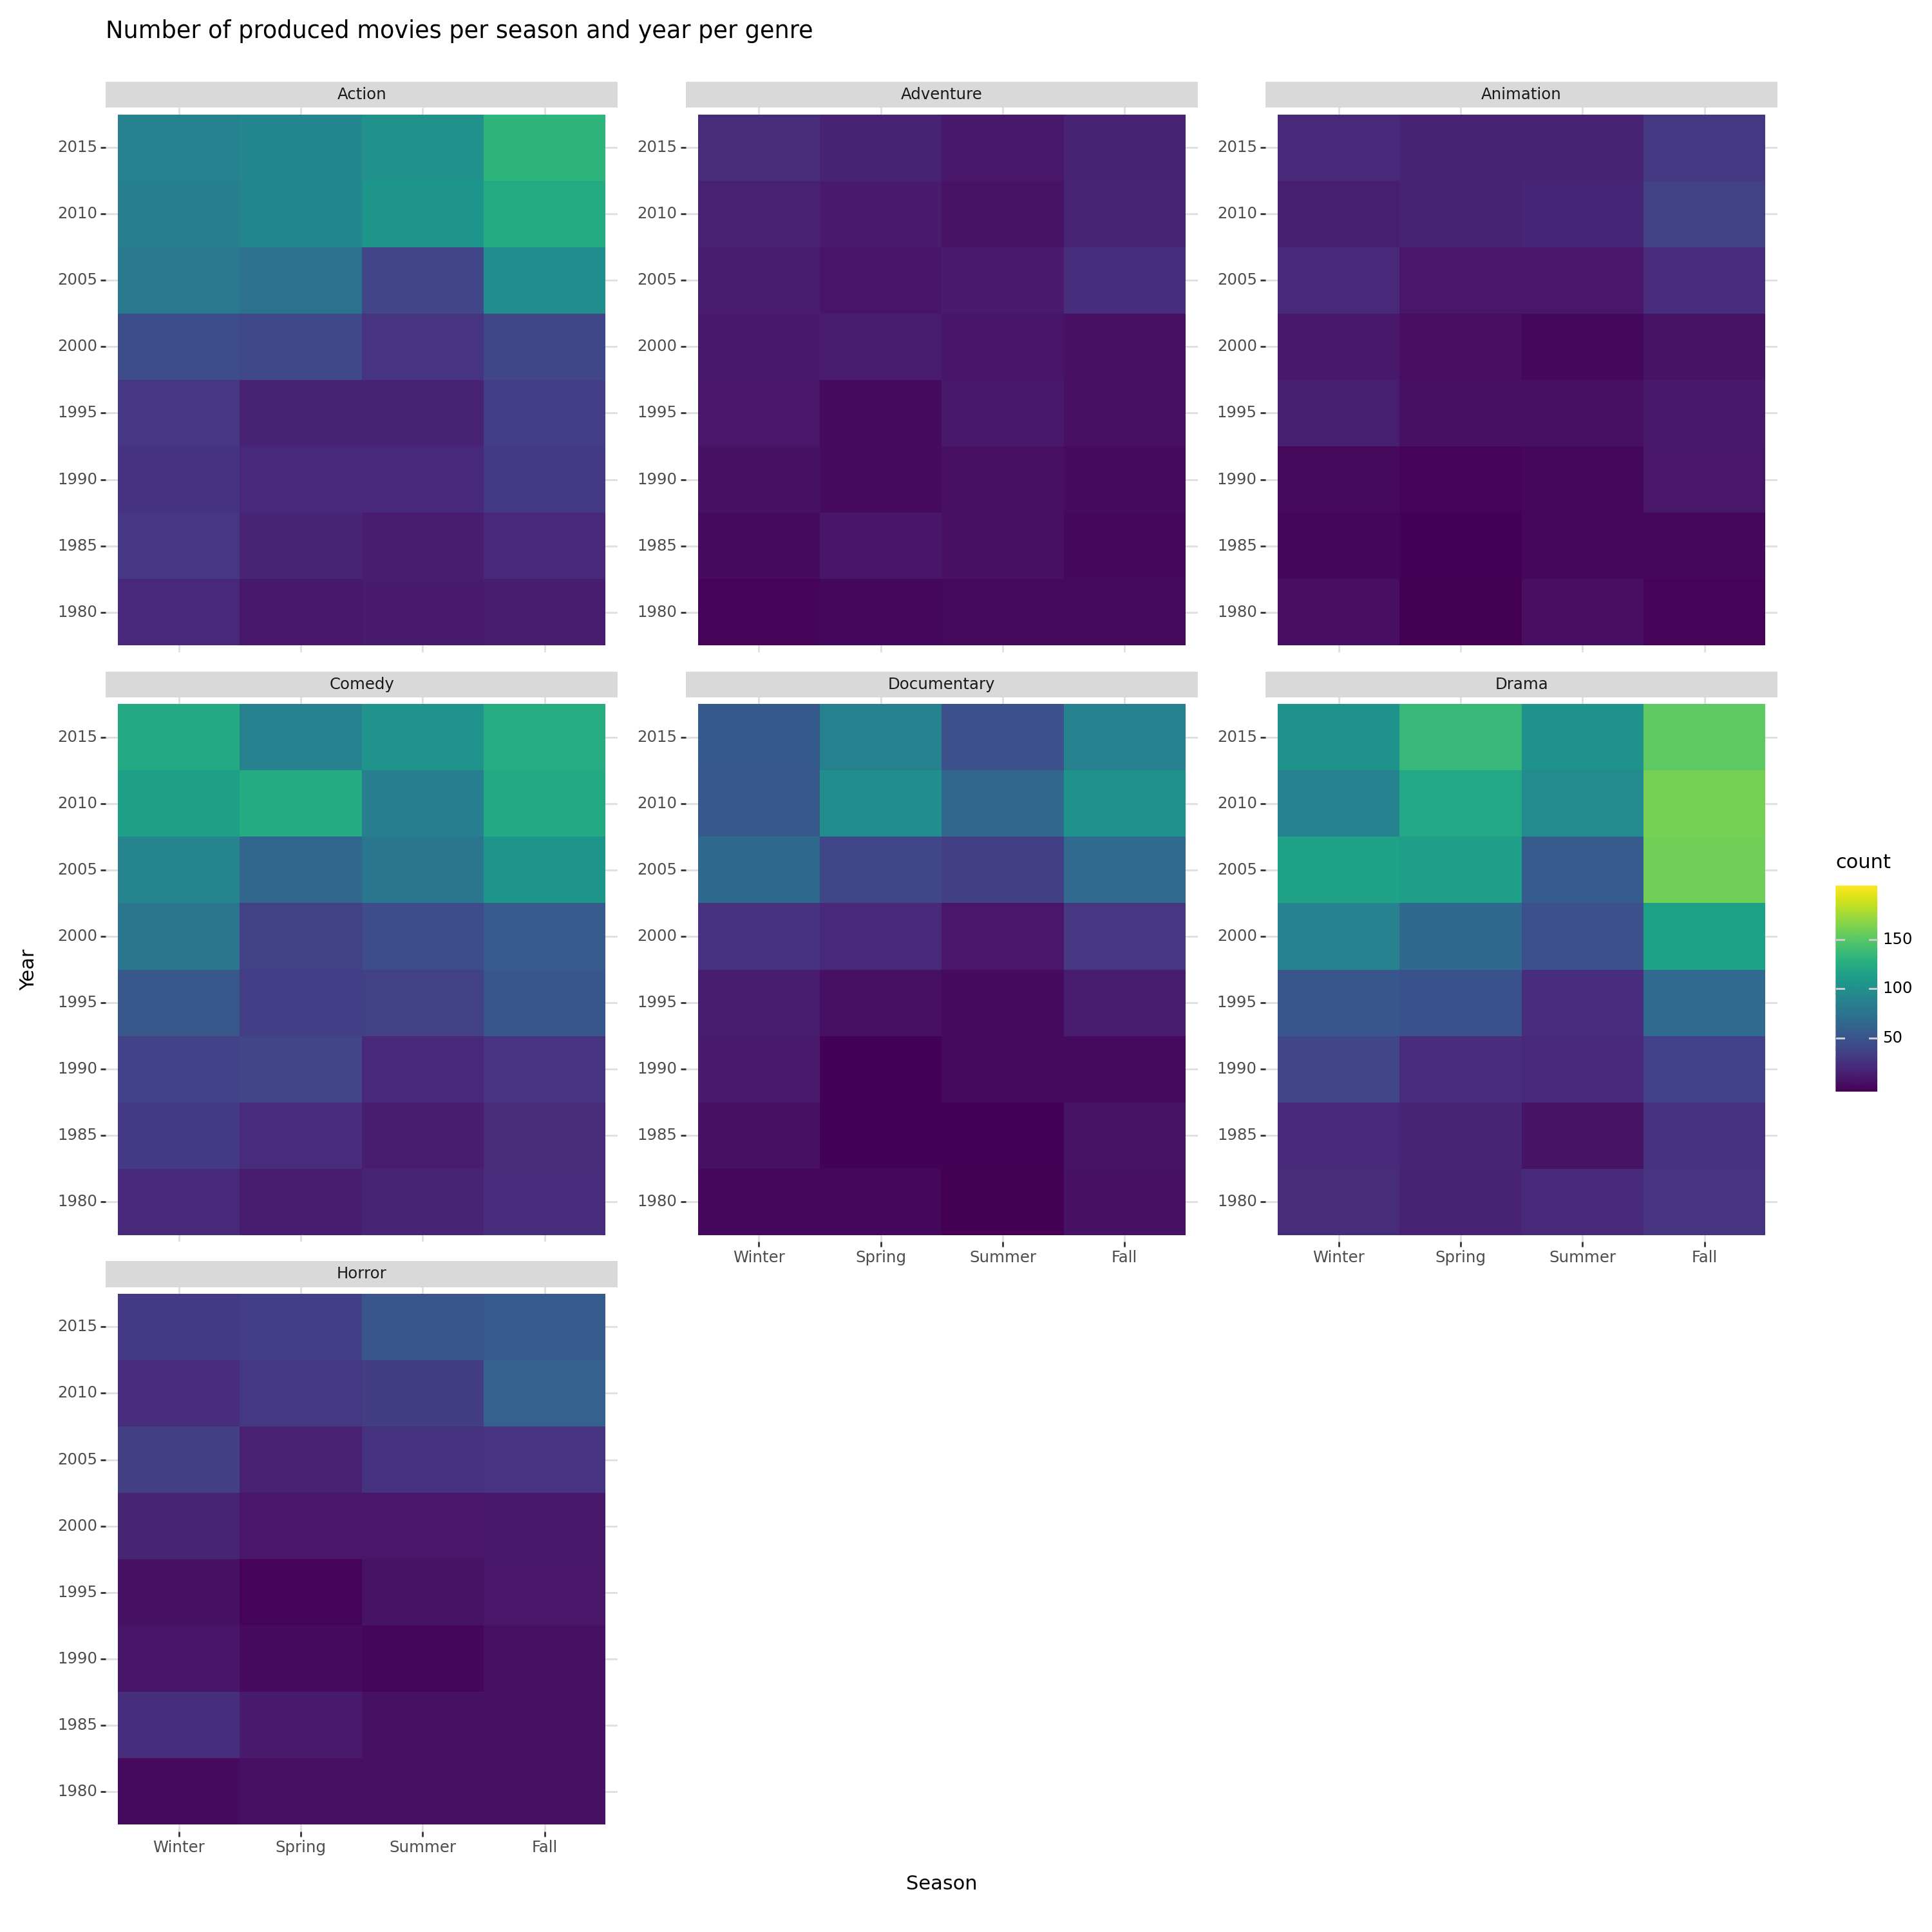

In [8]:
# For each genre create a facet_wrap with the number of movies per season and year. Have a different Y axis for each genre

df_season_genre_count = (
    df_main.groupby(["season", "release_year", "main_genre"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

df_season_genre_count["release_year"] = df_season_genre_count["release_year"].apply(
    lambda x: x - x % 5
)

df_season_genre_count["release_year"] = pd.Categorical(
    df_season_genre_count["release_year"],
    sorted(df_season_genre_count["release_year"].unique()),
)

df_season_genre_count["season"] = pd.Categorical(
    df_season_genre_count["season"], ["Winter", "Spring", "Summer", "Fall"]
)

p = (
    p9.ggplot(
        df_season_genre_count,
        p9.aes("season", "release_year", fill="count"),
    )
    + p9.geom_tile()
    + p9.labs(
        x="Season",
        y="Year",
        title="Number of produced movies per season and year per genre",
    )
    + p9.facet_wrap("main_genre", scales="free_y")
    + p9.theme(
        figure_size=(15, 15),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)

p.draw()


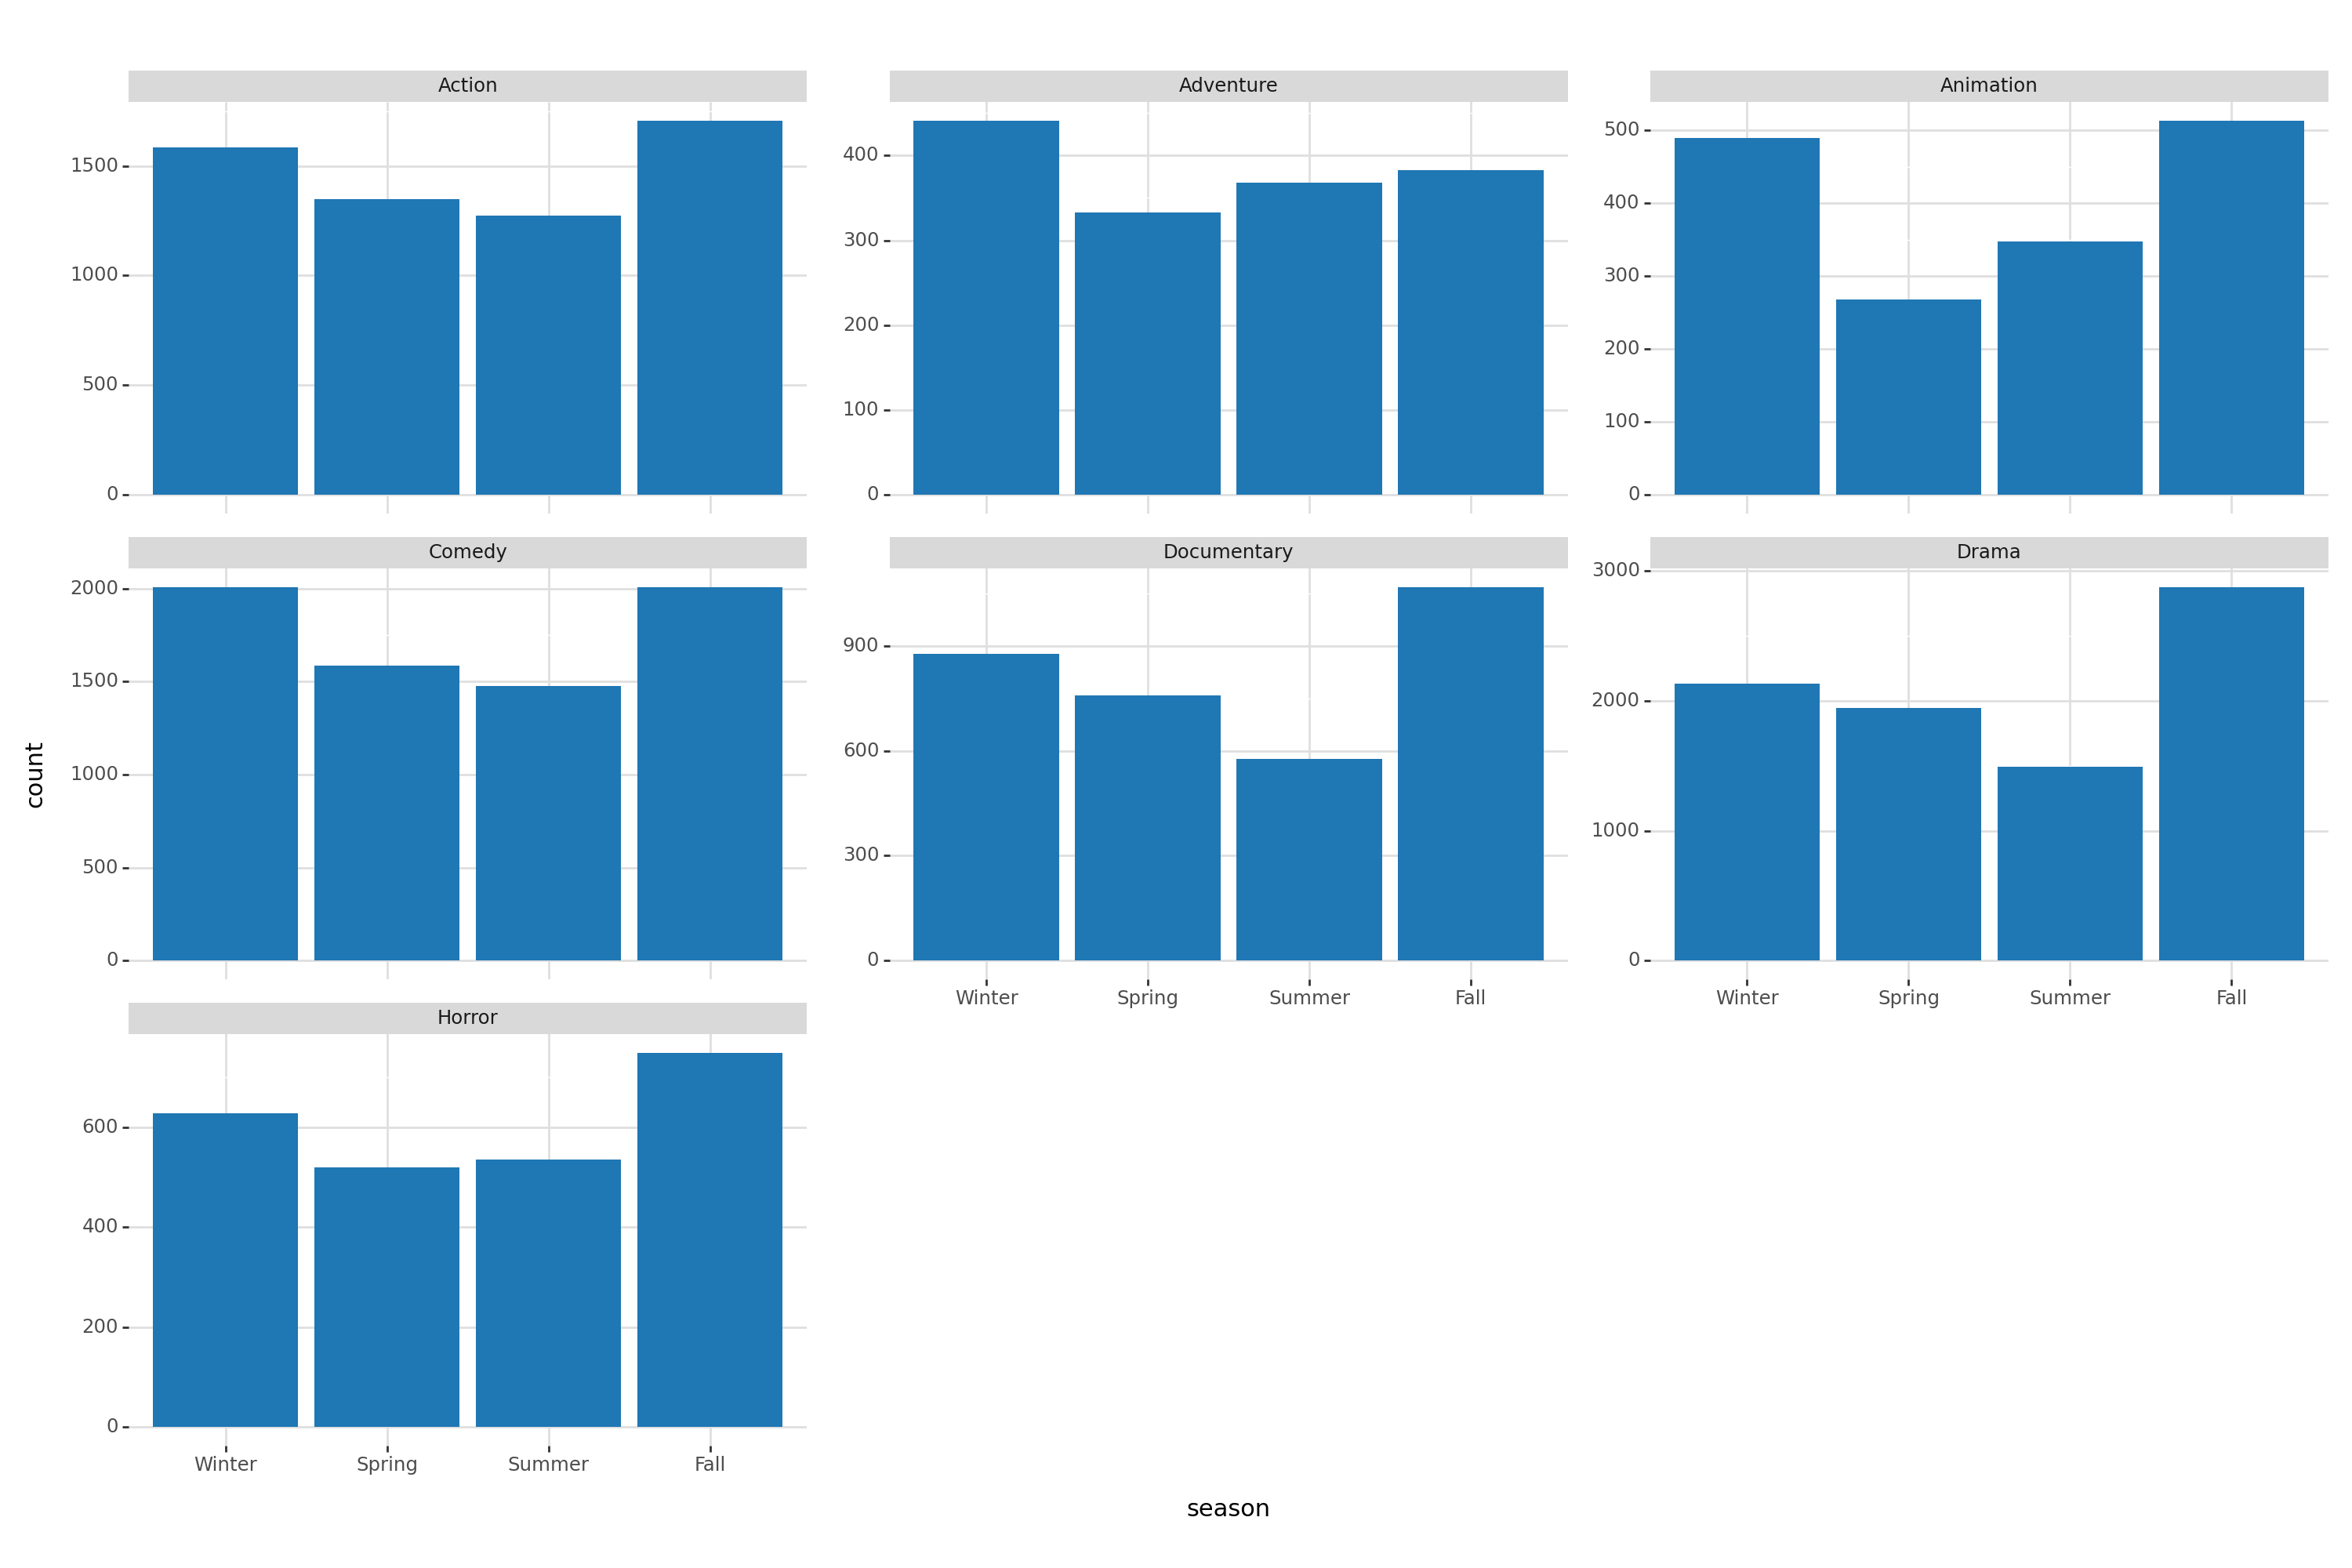

In [9]:
# Create a bar chart with facet wrap for the genre and the number of movies per season. Have a different Y axis for each genre

df_season_genre_count = (
    df_main.groupby(["season", "main_genre"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

df_season_genre_count["season"] = pd.Categorical(
    df_season_genre_count["season"], ["Winter", "Spring", "Summer", "Fall"]
)

p = (
    p9.ggplot(
        df_season_genre_count,
        p9.aes("season", "count"),
    )
    + p9.geom_col(position="stack", fill="#1f77b4")
    + p9.facet_wrap("main_genre", scales="free_y")
    + p9.theme(
        figure_size=(15, 10),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)

p.draw()


season  count
Winter  8153     1
Spring  6757     1
Summer  6070     1
Fall    9302     1
Name: count, dtype: int64


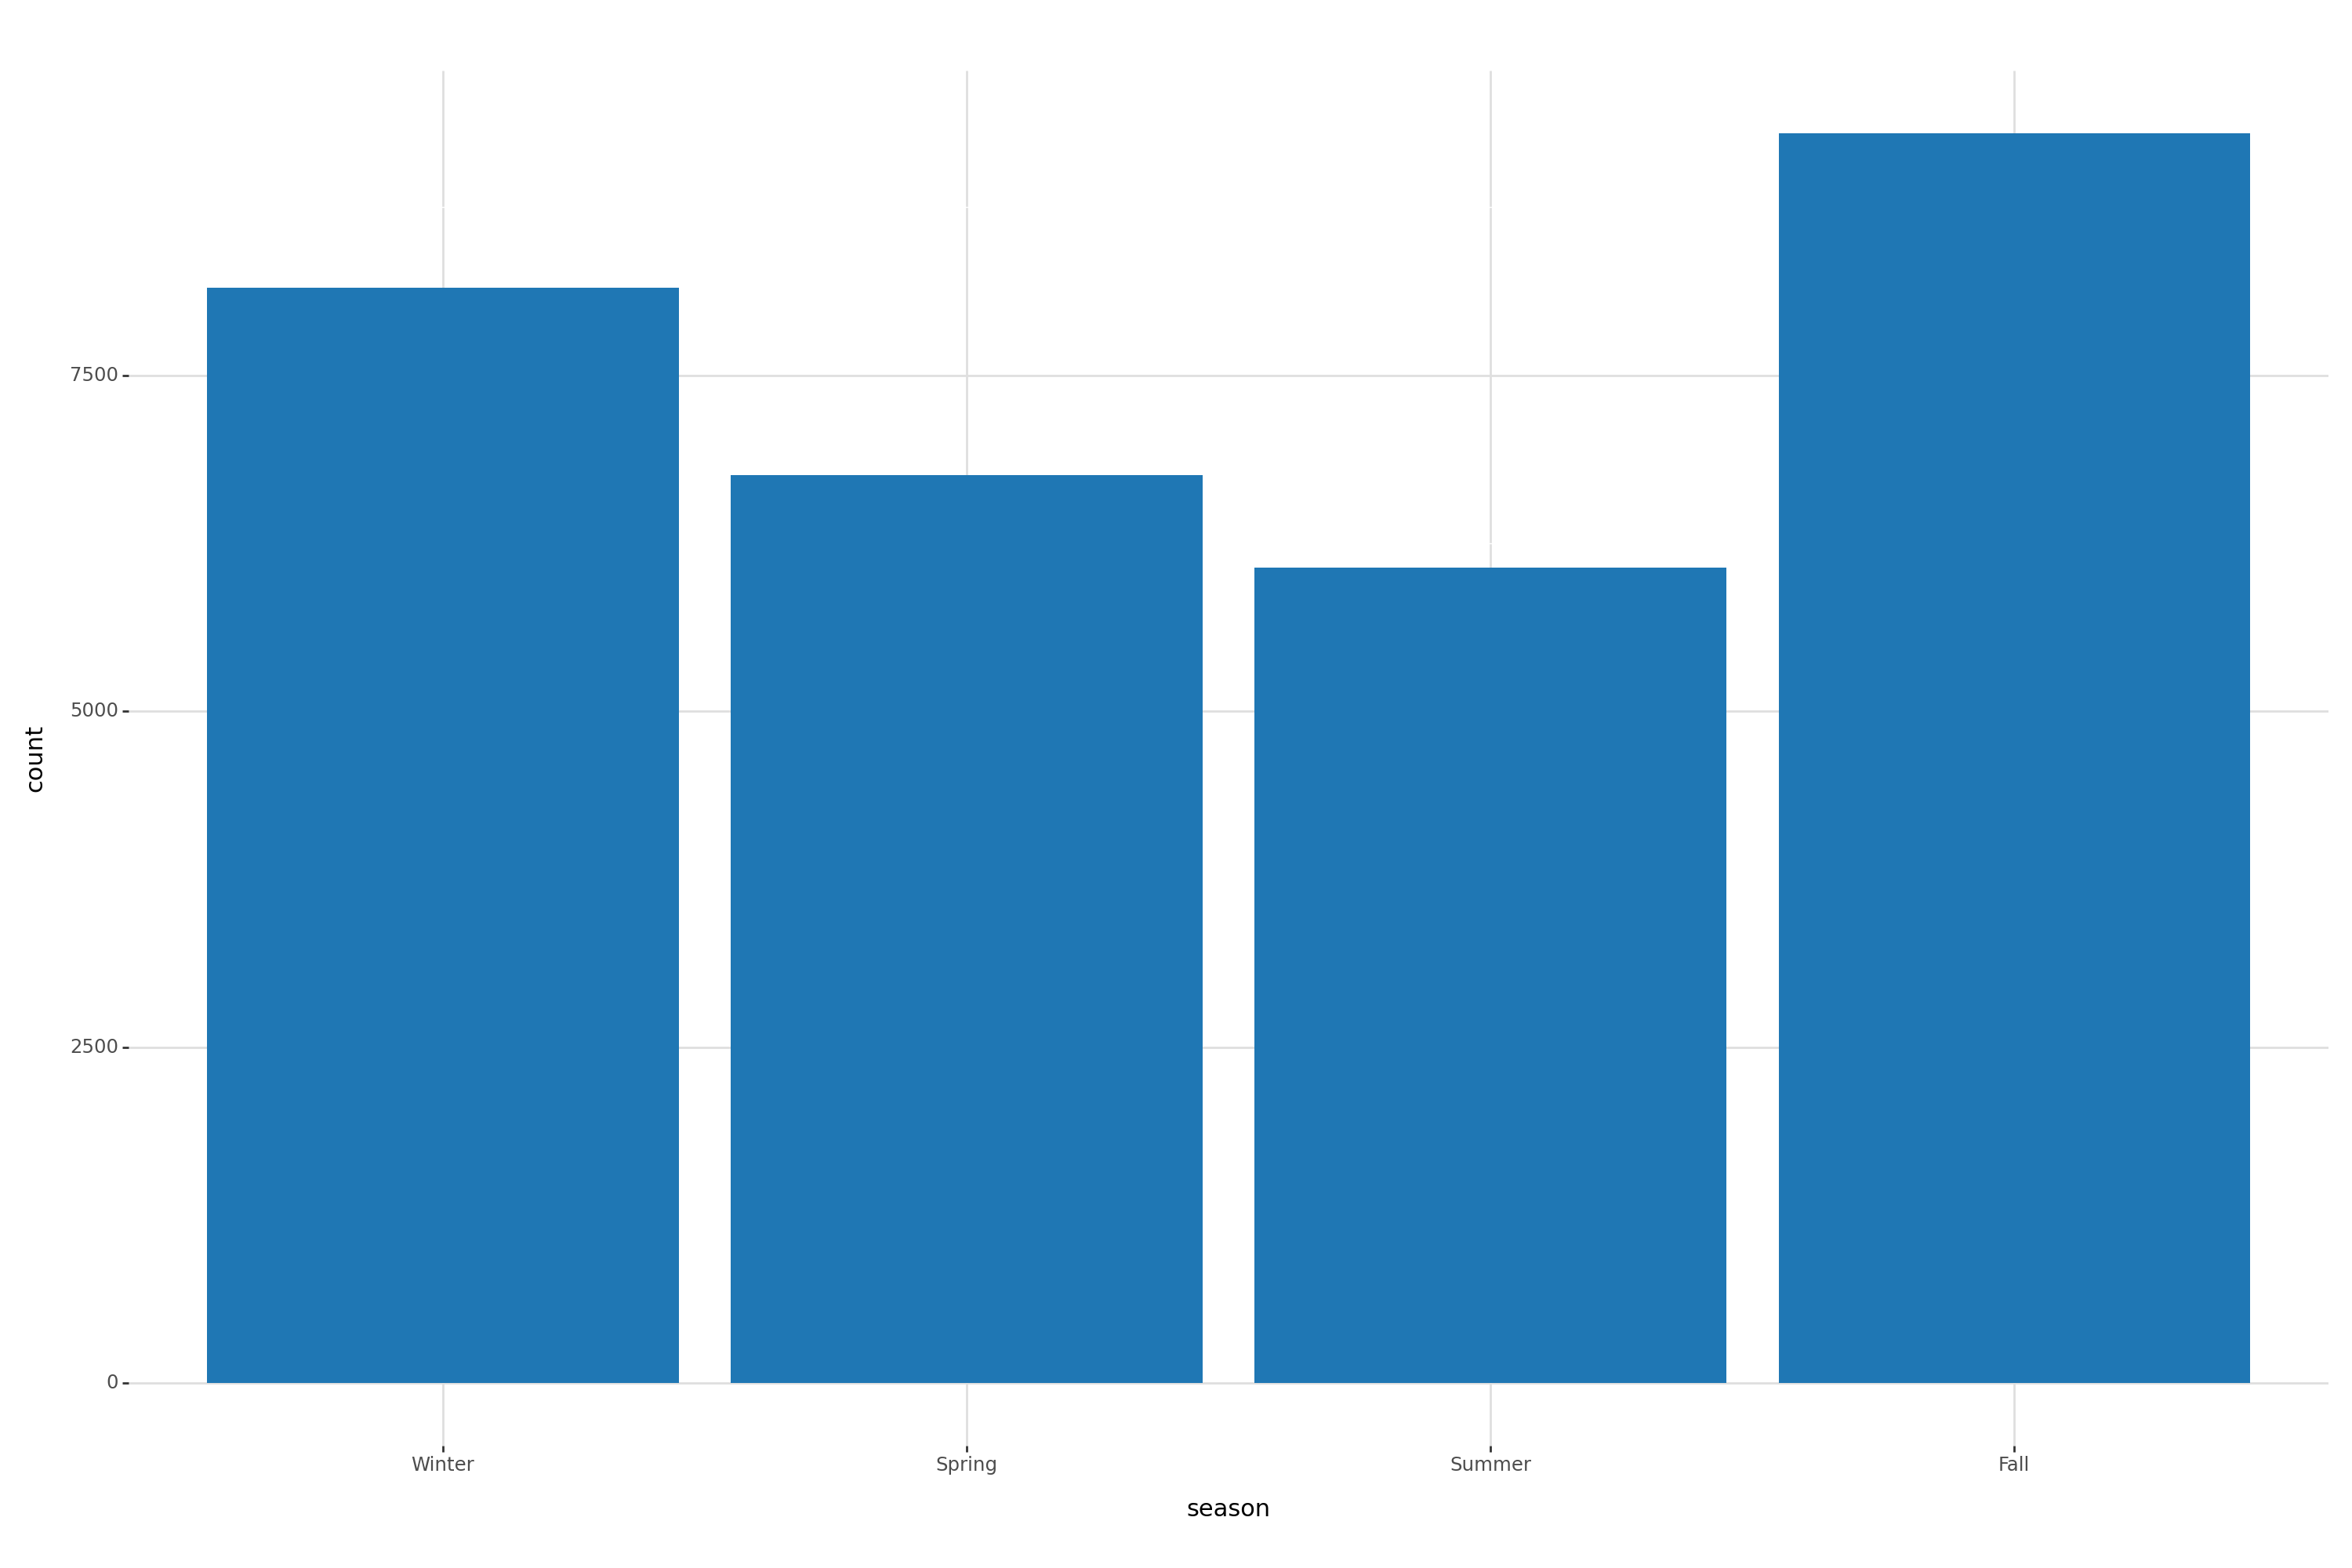

In [10]:
# Total number of movies per season
df_season_count = (
    df_main.groupby(["season"])
    .size()
    .reset_index()
    .rename(columns={0: "count"})
)

df_season_count["season"] = pd.Categorical(
    df_season_count["season"], ["Winter", "Spring", "Summer", "Fall"]
)

p = (
    p9.ggplot(
        df_season_count,
        p9.aes("season", "count"),
    )
    + p9.geom_col(position="stack", fill="#1f77b4")
    + p9.theme(
        figure_size=(15, 10),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)
print(df_season_count.value_counts())
p.draw()


In [8]:
df_main["main_genre"] = df_main["genres"].apply(
    lambda x: x[0].strip() if len(x) > 0 else None
)
df_main.dropna(subset=["main_genre"], inplace=True)


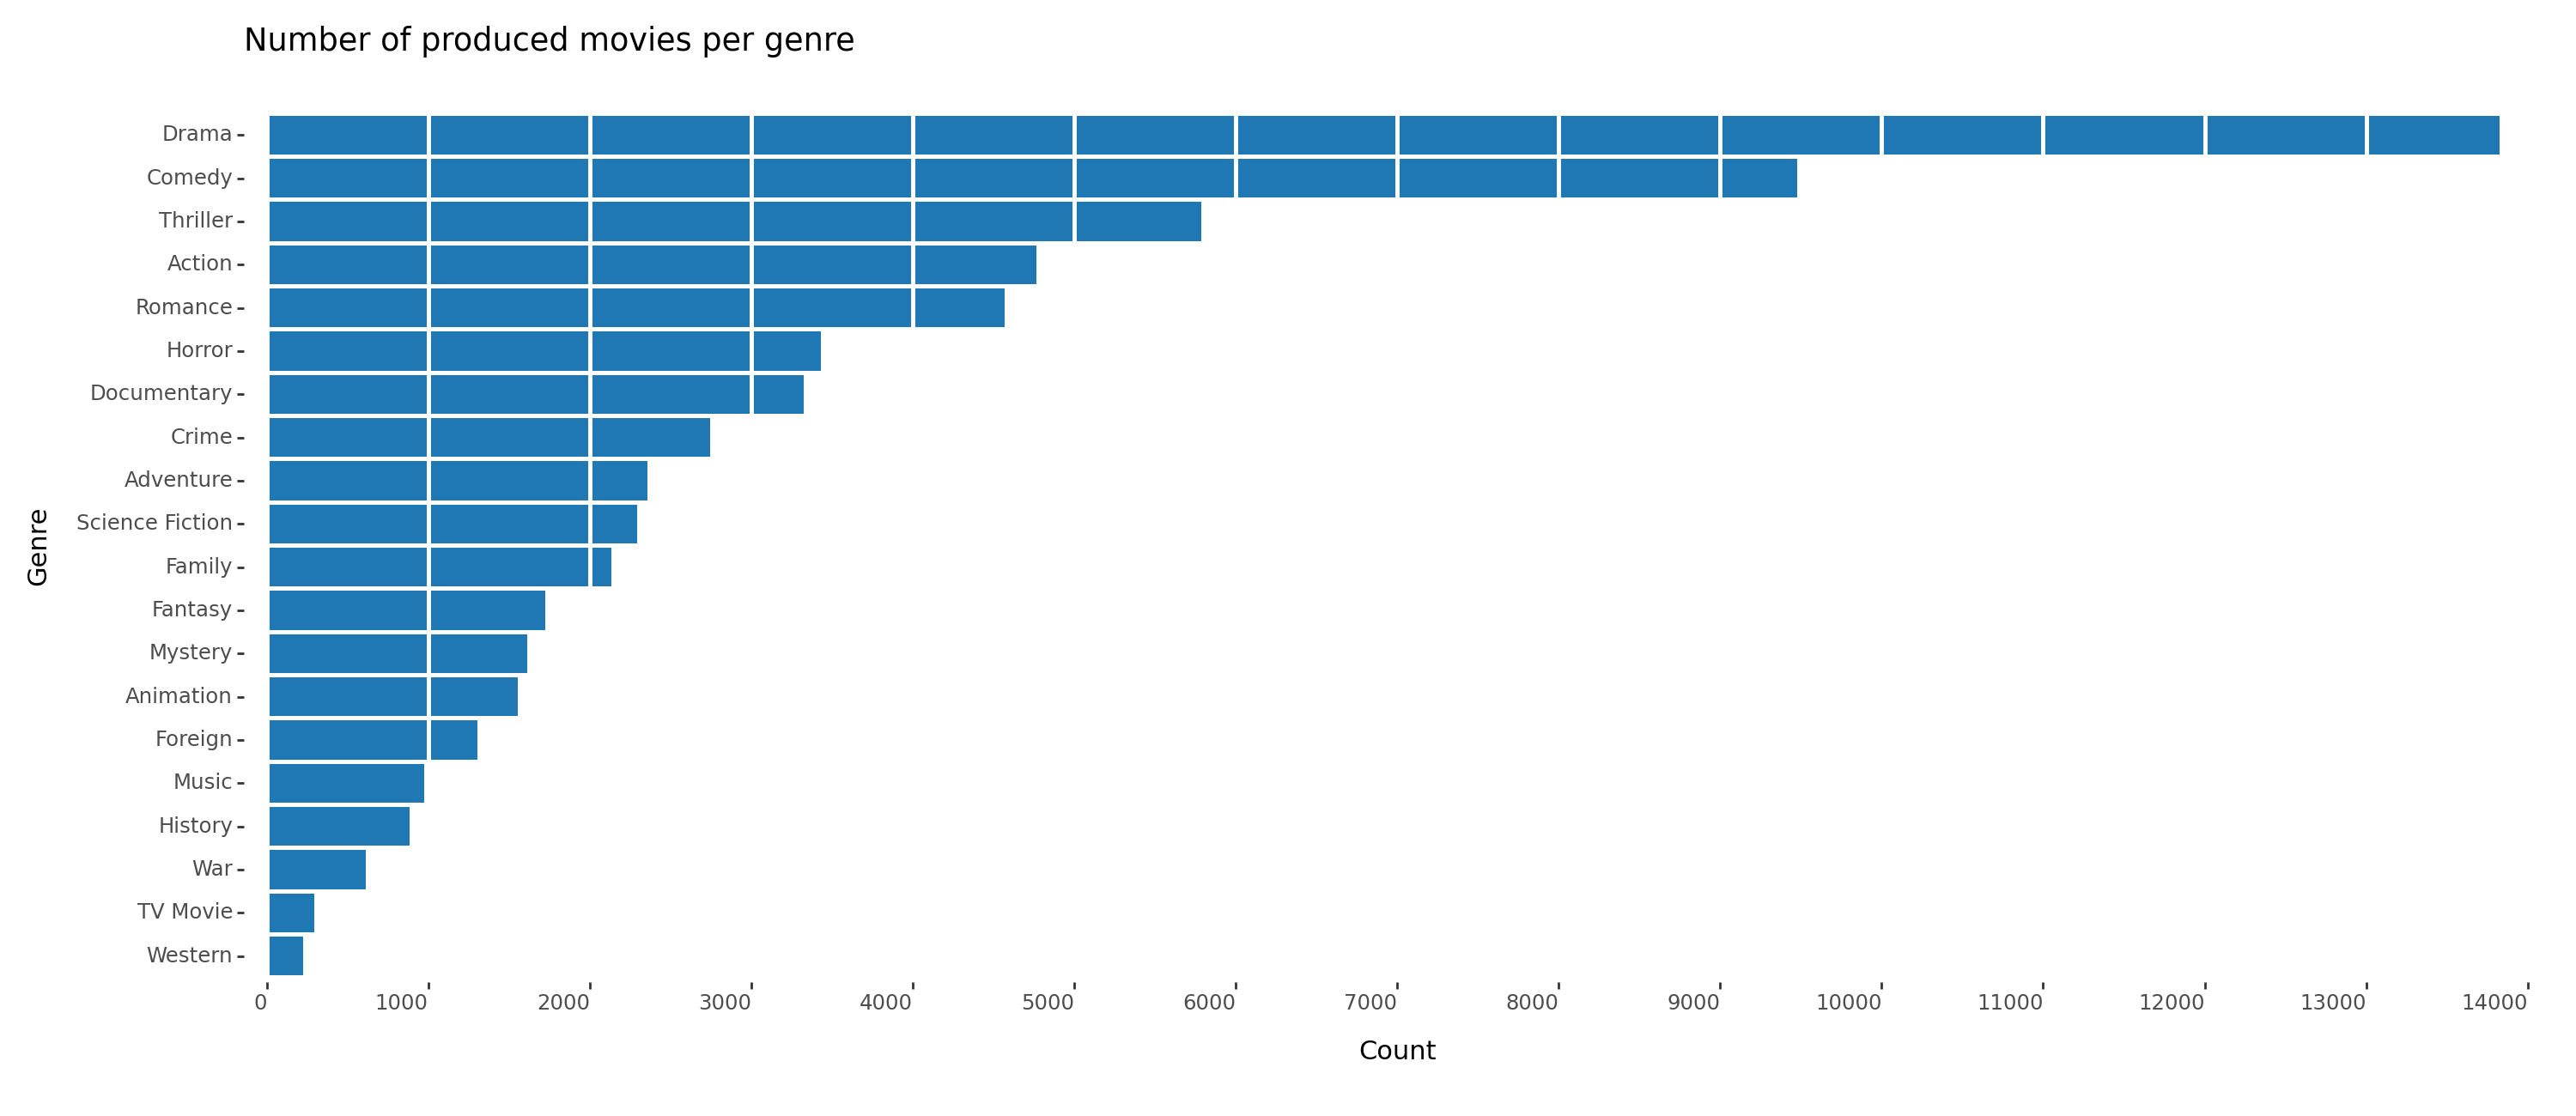

In [27]:
df_genres = df_main.explode("genres")
df_genres = df_genres.dropna(subset=["genres"])
df_genres["genres"] = df_genres["genres"].str.strip()
df_genres_count = df_genres.groupby("genres").size().reset_index(name="count")
df_genres_count = df_genres_count.sort_values(by="count", ascending=False)

p = (
    p9.ggplot(df_genres_count, p9.aes("reorder(genres, count)", "count", fill="genres"))
    + p9.geom_bar(stat="identity", fill="#1f77b4")
    + p9.coord_flip()
    + p9.theme(legend_position="none")
    + p9.scale_y_continuous(breaks=range(0, 15000, 1000), expand=(0.01, 0.01))
    + p9.labs(x="Genre", y="Count", title="Number of produced movies per genre")
    + p9.theme(
        axis_text_x=p9.element_text(rotation=0, hjust=1),
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#ffffff", size=0.5),
    )
    # overlay the bars with the grid lines
    + p9.geom_hline(yintercept=range(0, 15000, 1000), color="#ffffff", size=1)
    # reduce the space between the bars and the grid lines
    + p9.guides(color=p9.guide_legend(ncol=2))
)
p.draw()


(7, 2)


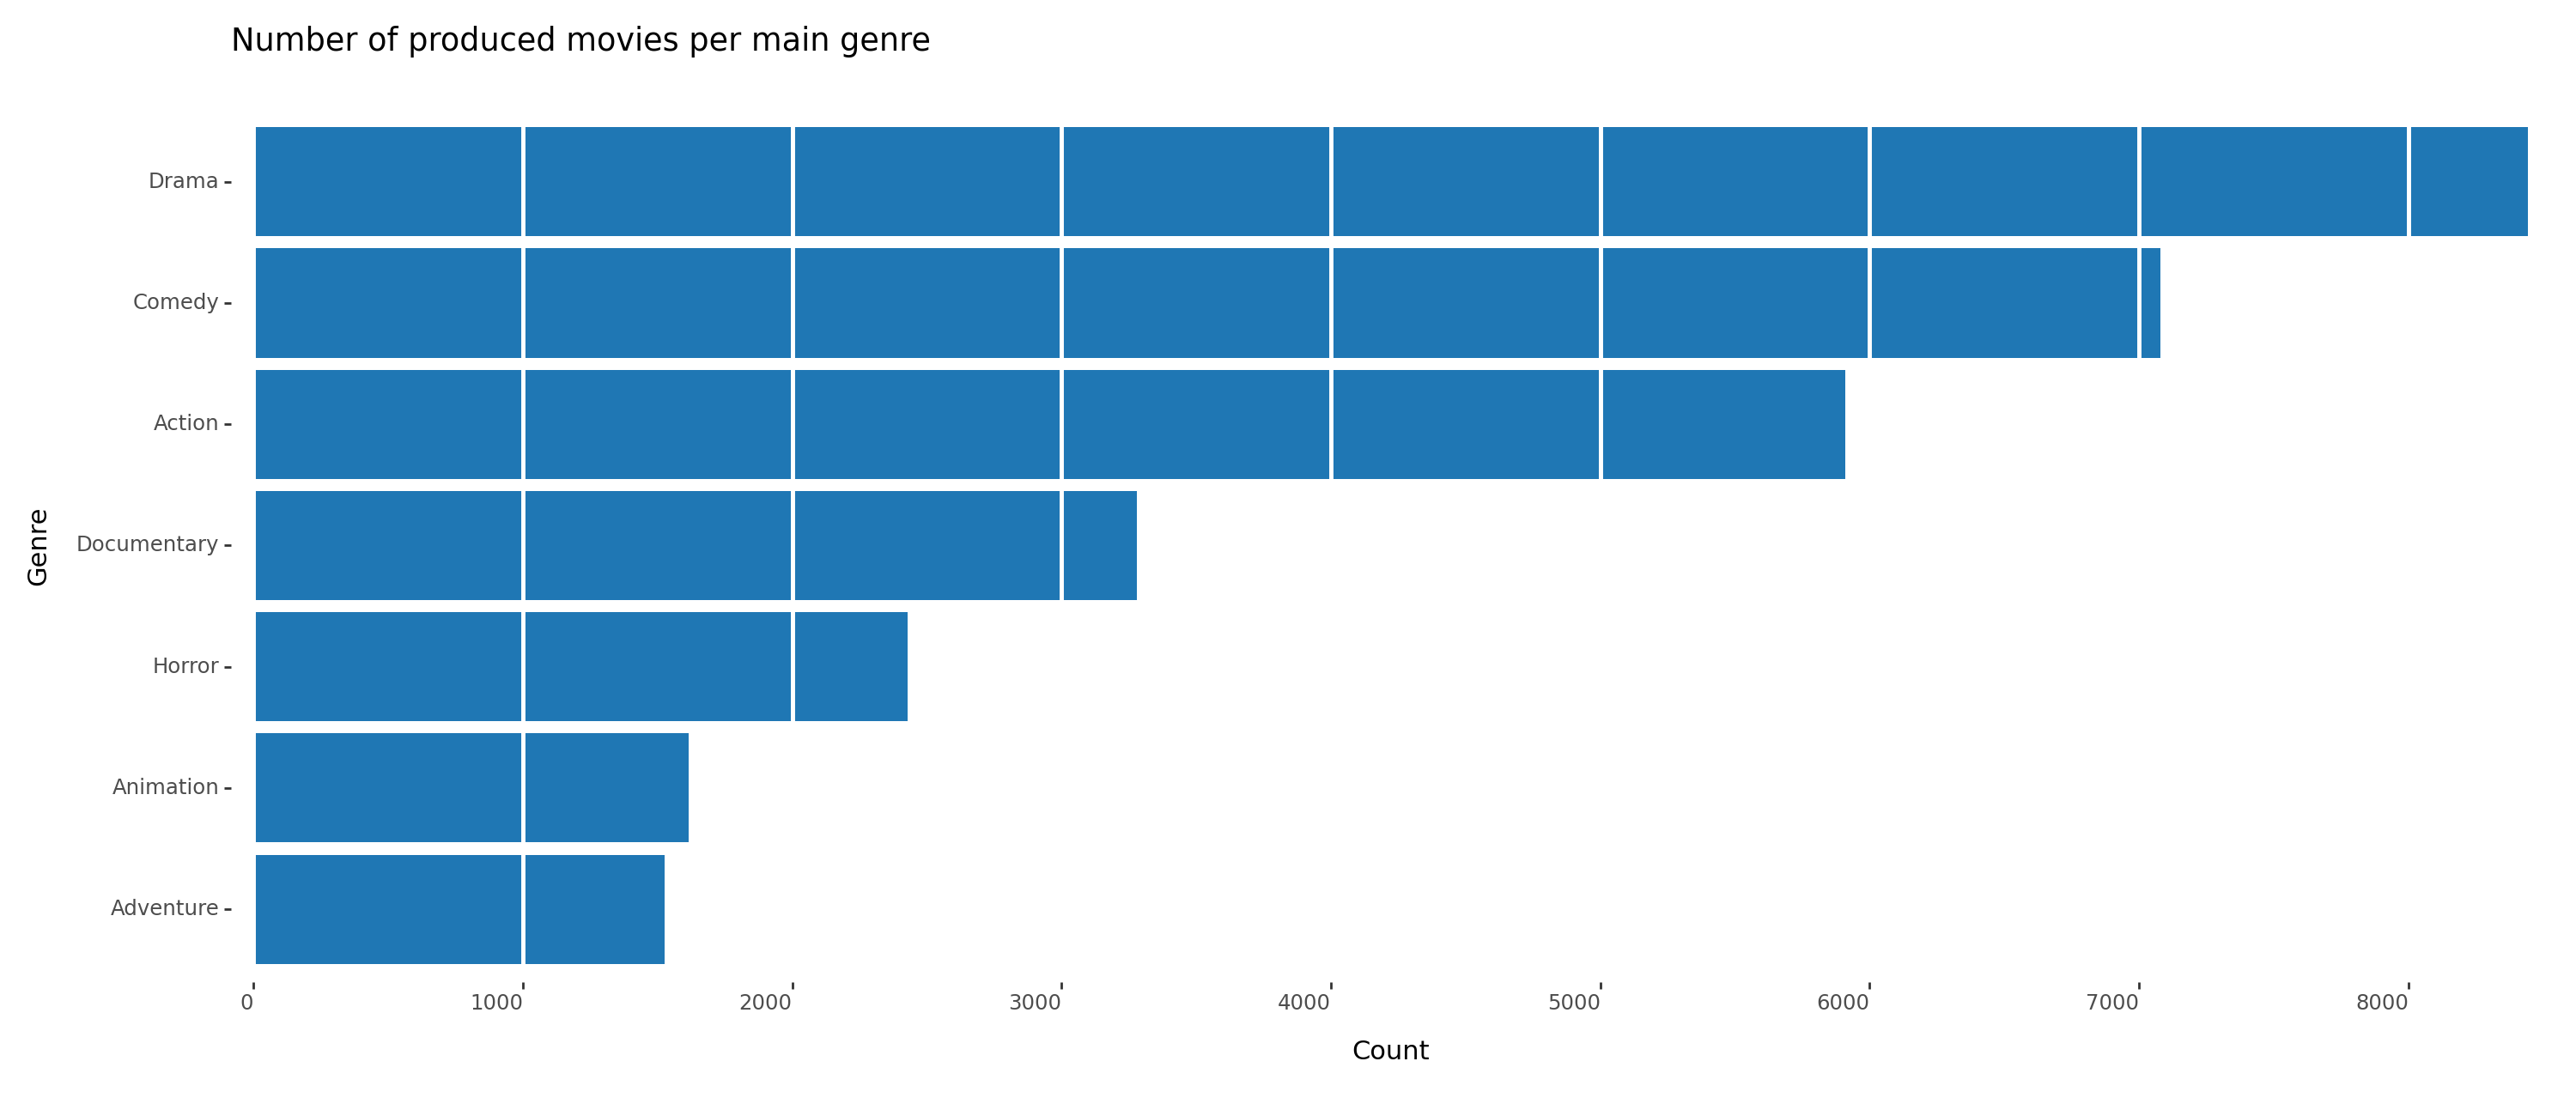

In [82]:
# Visualize the count by main genre
df_main_count = df_main.groupby("main_genre").size().reset_index(name="count")
df_main_count = df_main_count.sort_values(by="count", ascending=False)
print(df_main_count.shape)

p = (
    p9.ggplot(
        df_main_count, p9.aes("reorder(main_genre, count)", "count", fill="main_genre")
    )
    + p9.geom_bar(stat="identity", fill="#1f77b4")
    + p9.coord_flip()
    + p9.theme(legend_position="none")
    + p9.scale_y_continuous(breaks=range(0, 15000, 1000), expand=(0.01, 0.01))
    + p9.labs(x="Genre", y="Count", title="Number of produced movies per main genre")
    + p9.theme(
        axis_text_x=p9.element_text(rotation=0, hjust=1),
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#ffffff", size=0.5),
    )
    # overlay the bars with the grid lines
    + p9.geom_hline(yintercept=range(0, 9000, 1000), color="#ffffff", size=1)
    # reduce the space between the bars and the grid lines
    + p9.guides(color=p9.guide_legend(ncol=2))
)
p.draw()


(7, 2)


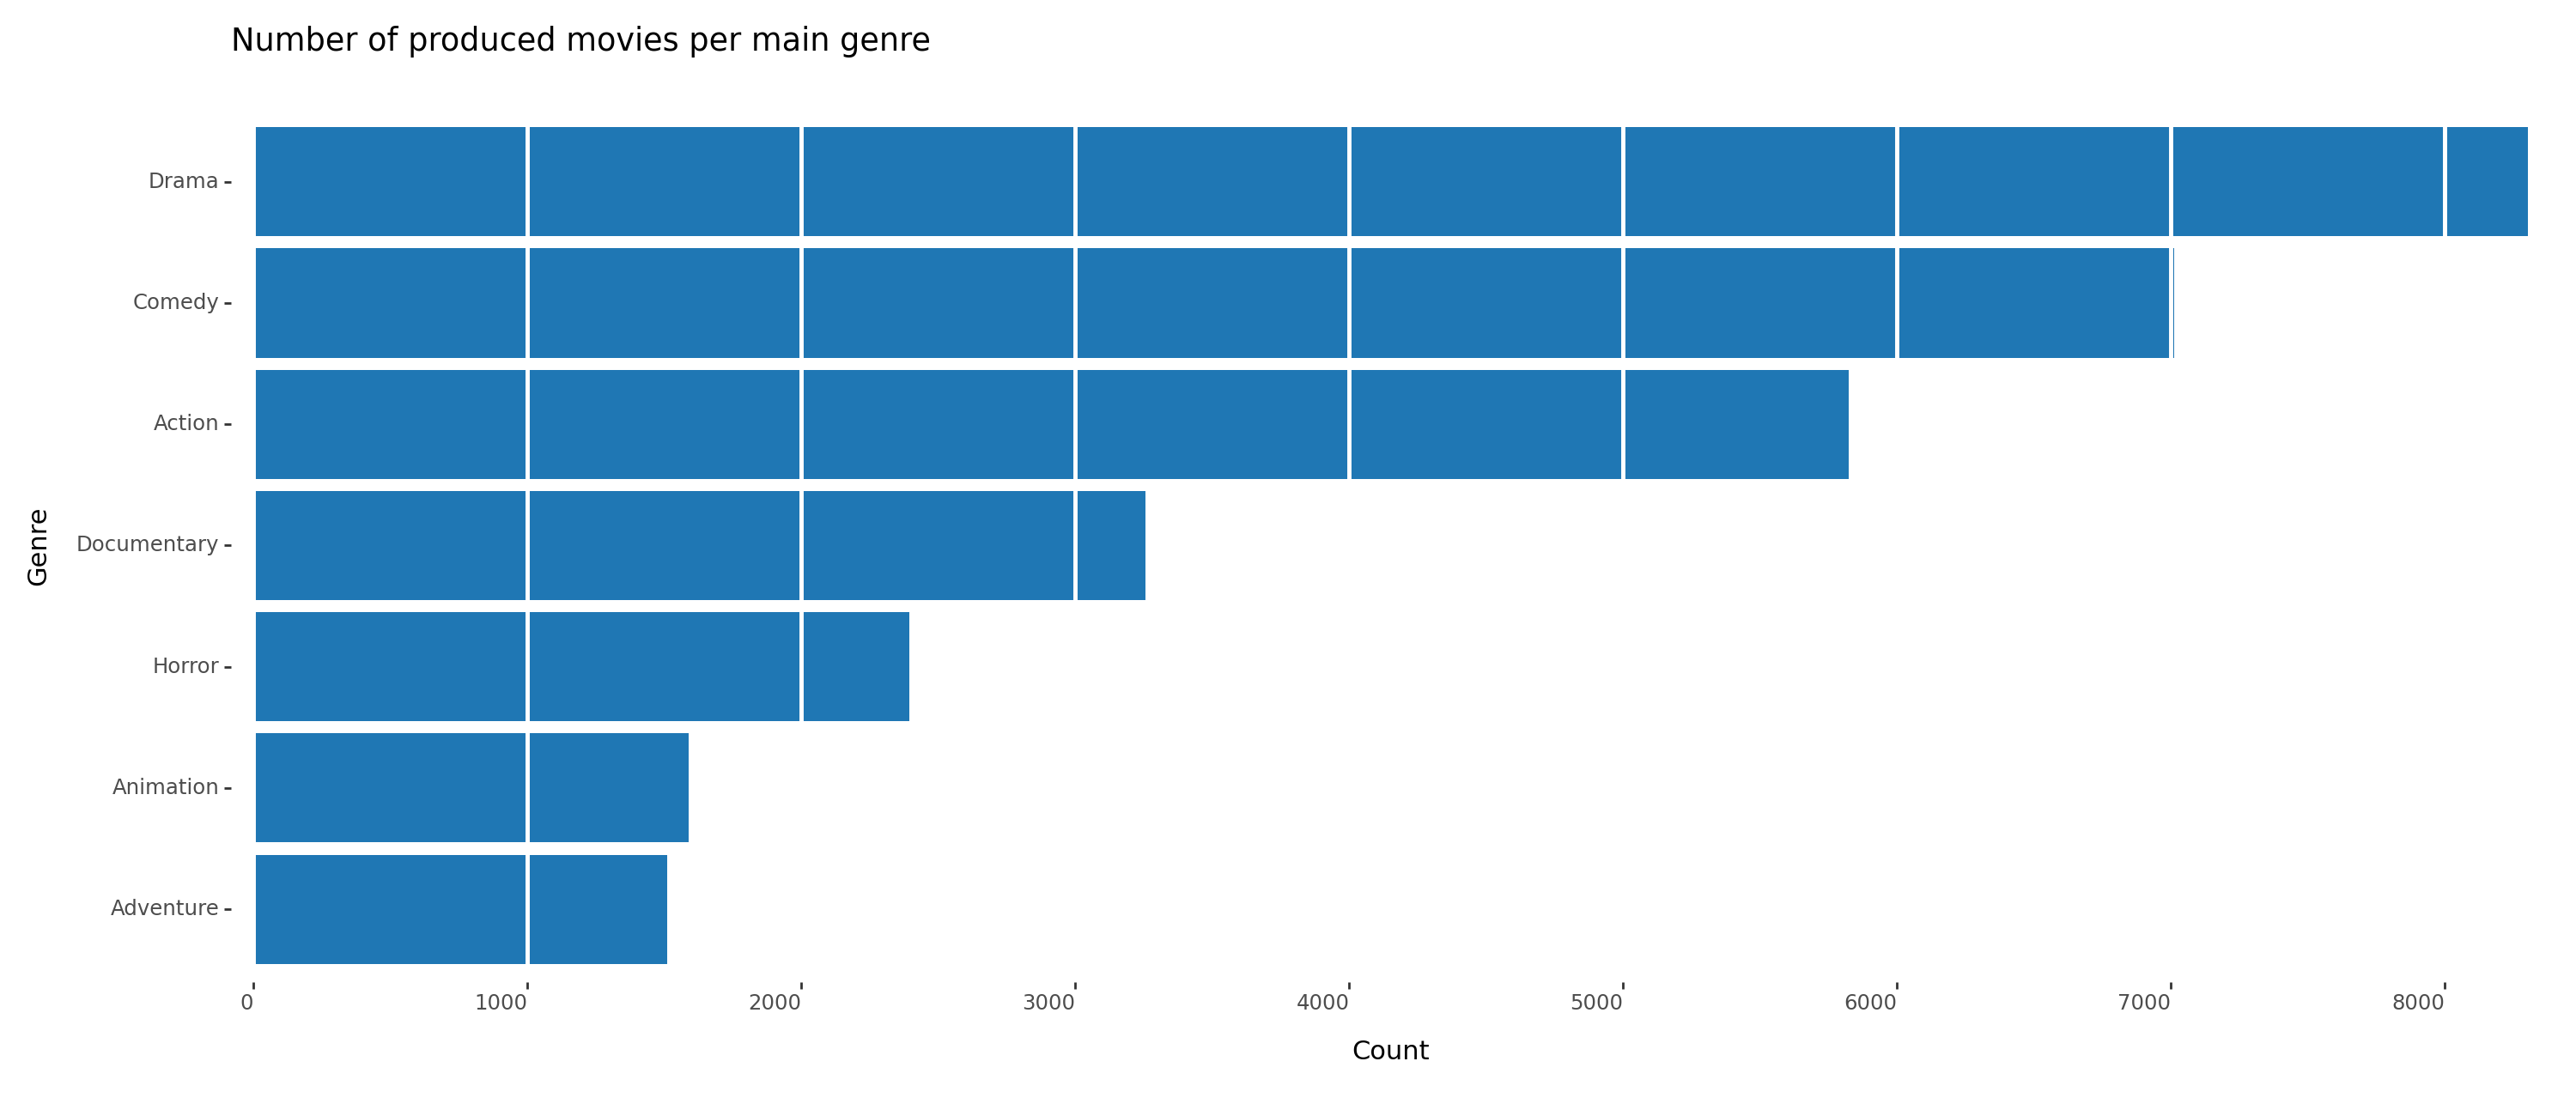

In [26]:
# Visualize the count by main genre
df_main_count = df_main.groupby("main_genre").size().reset_index(name="count")
df_main_count = df_main_count.sort_values(by="count", ascending=False)
print(df_main_count.shape)

p = (
    p9.ggplot(
        df_main_count, p9.aes("reorder(main_genre, count)", "count", fill="main_genre")
    )
    + p9.geom_bar(stat="identity", fill="#1f77b4")
    + p9.coord_flip()
    + p9.theme(legend_position="none")
    + p9.scale_y_continuous(breaks=range(0, 15000, 1000), expand=(0.01, 0.01))
    + p9.labs(x="Genre", y="Count", title="Number of produced movies per main genre")
    + p9.theme(
        axis_text_x=p9.element_text(rotation=0, hjust=1),
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#ffffff", size=0.5),
    )
    # overlay the bars with the grid lines
    + p9.geom_hline(yintercept=range(0, 9000, 1000), color="#ffffff", size=1)
    # reduce the space between the bars and the grid lines
    + p9.guides(color=p9.guide_legend(ncol=2))
)

p.draw()


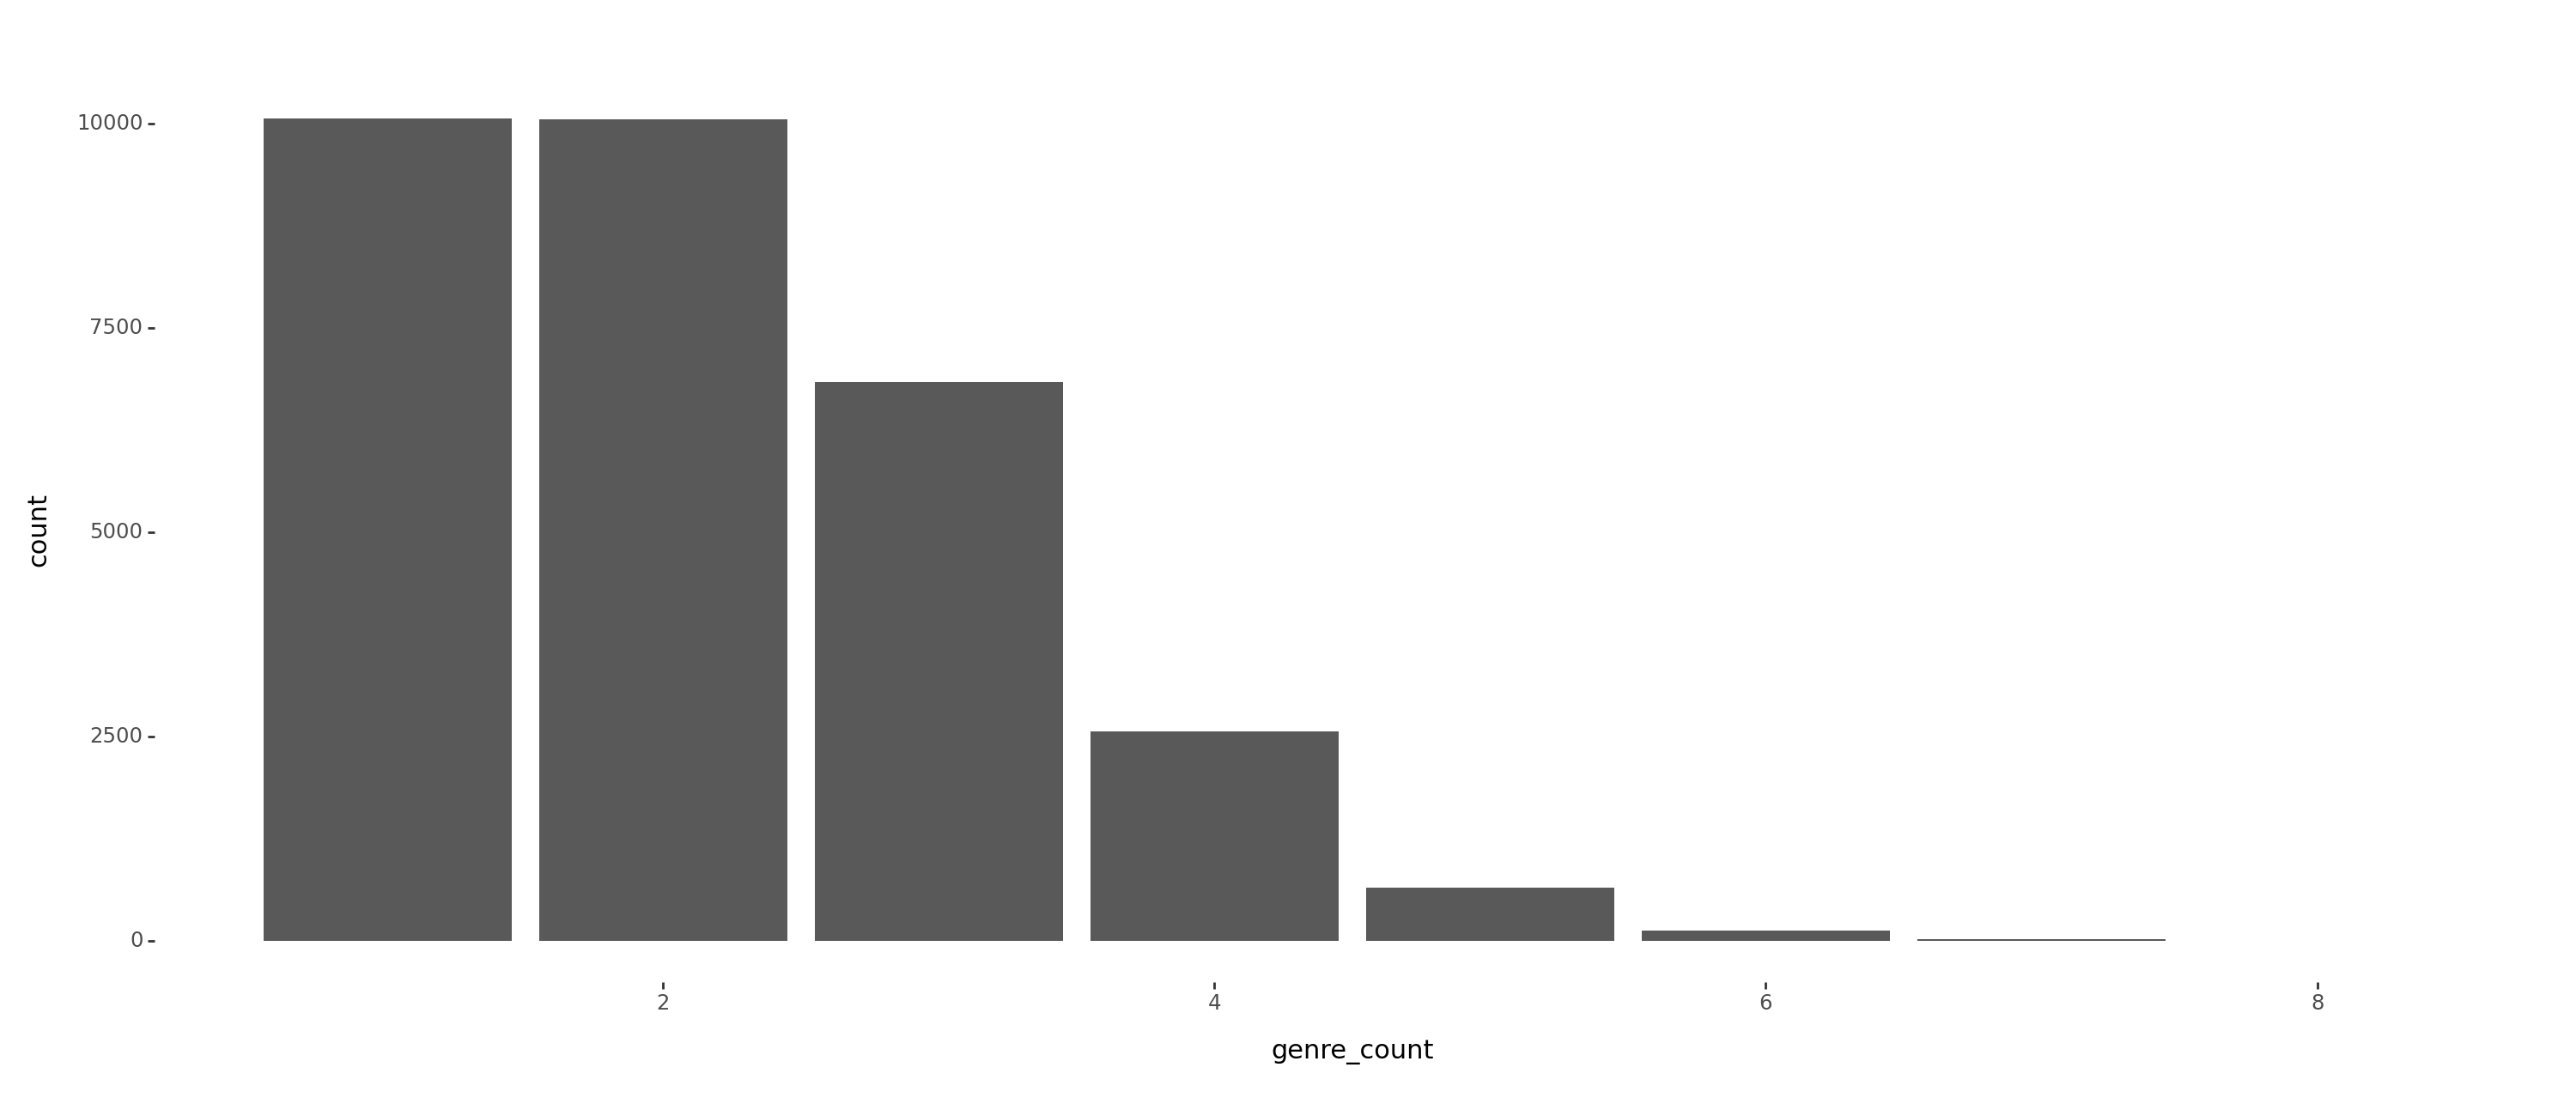

In [12]:
df_genre_counts = df_main.copy()
df_genre_counts["genre_count"] = df_genre_counts["genres"].apply(lambda x: len(set(x)))
# group the movies by the number of genres they have
df_genre_counts.groupby("genre_count").size().reset_index(name="count")

p = (
    p9.ggplot(df_genre_counts, p9.aes("genre_count", fill="genre_count"))
    + p9.geom_bar()
    + p9.scale_fill_gradient(low="#1f77b4", high="#ff7f0e")
    + p9.theme(
        legend_position="none",
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#ffffff", size=0.5),
    )
)
p.draw()


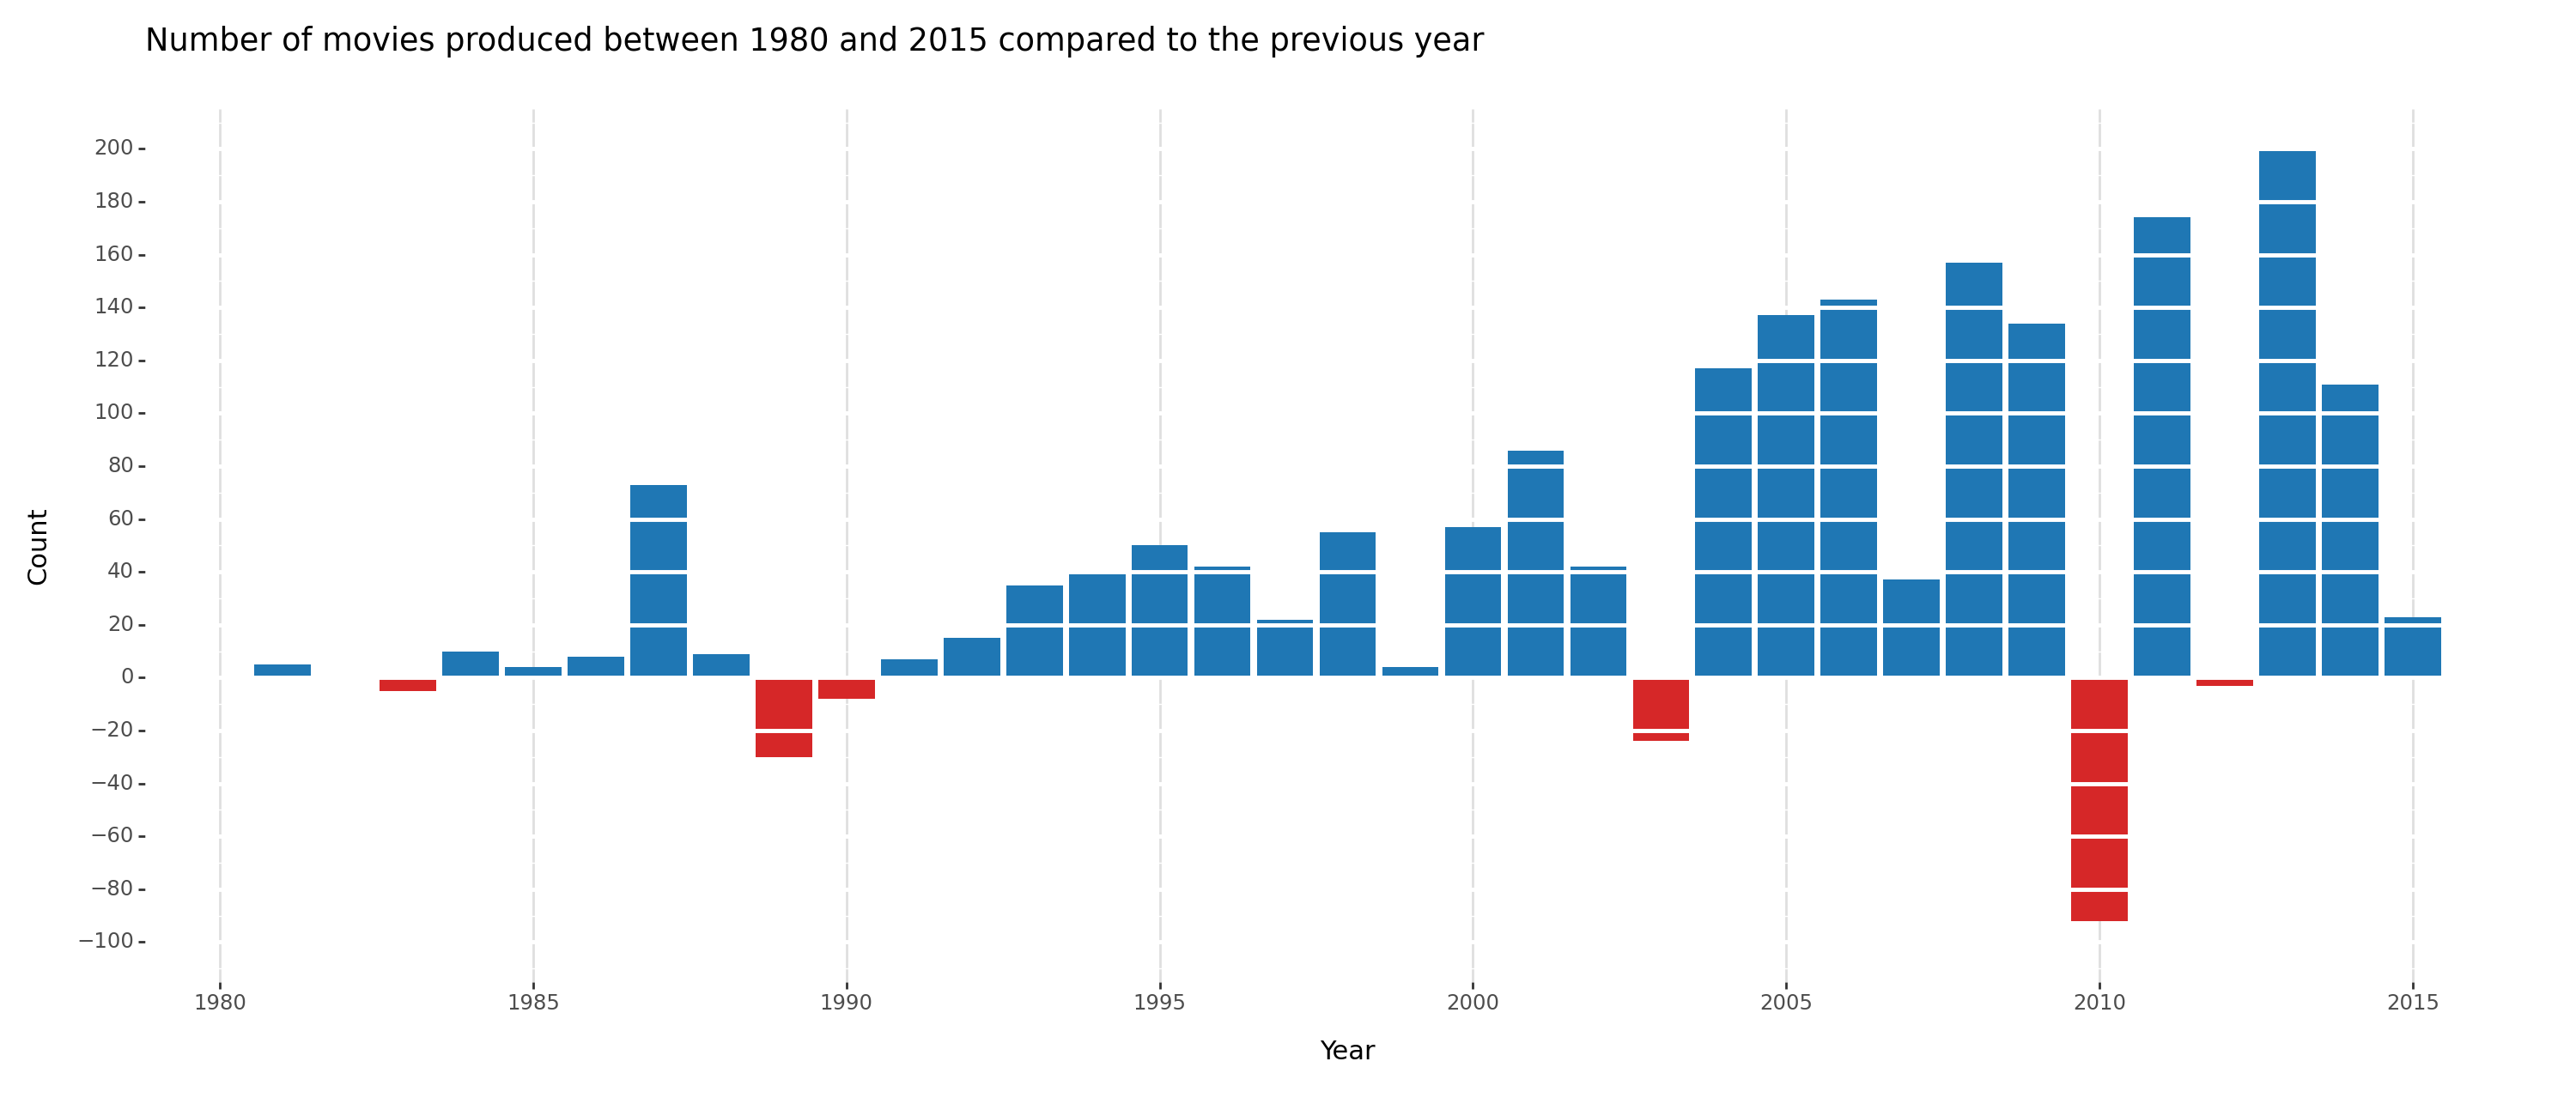

In [13]:
# Let's now see how the number of movies produced per year has evolved.
df_year_count = df_main.groupby("release_year").size().reset_index(name="count")
df_year_count = df_year_count.sort_values(by="release_year", ascending=True)
df_year_count["count"] = df_year_count["count"].astype(int)

df_year_count["count"] = df_year_count["count"].diff()
df_year_count = df_year_count.dropna(subset=["count"])
df_year_count["count"] = df_year_count["count"].astype(int)

p = (
    p9.ggplot(df_year_count, p9.aes("release_year", "count"))
    + p9.geom_bar(stat="identity", fill="#1f77b4")
    + p9.geom_bar(
        data=df_year_count[df_year_count["count"] < 0], stat="identity", fill="#d62728"
    )
    + p9.labs(
        x="Year",
        y="Count",
        title="Number of movies produced between 1980 and 2015 compared to the previous year",
    )
    + p9.scale_x_continuous(breaks=range(1970, 2016, 5))
    + p9.scale_y_continuous(breaks=range(-100, 210, 20), expand=(0.05, 0.05))
    + p9.geom_hline(yintercept=range(-100, 210, 20), color="#ffffff", size=1)
    + p9.theme(
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)
p.draw()


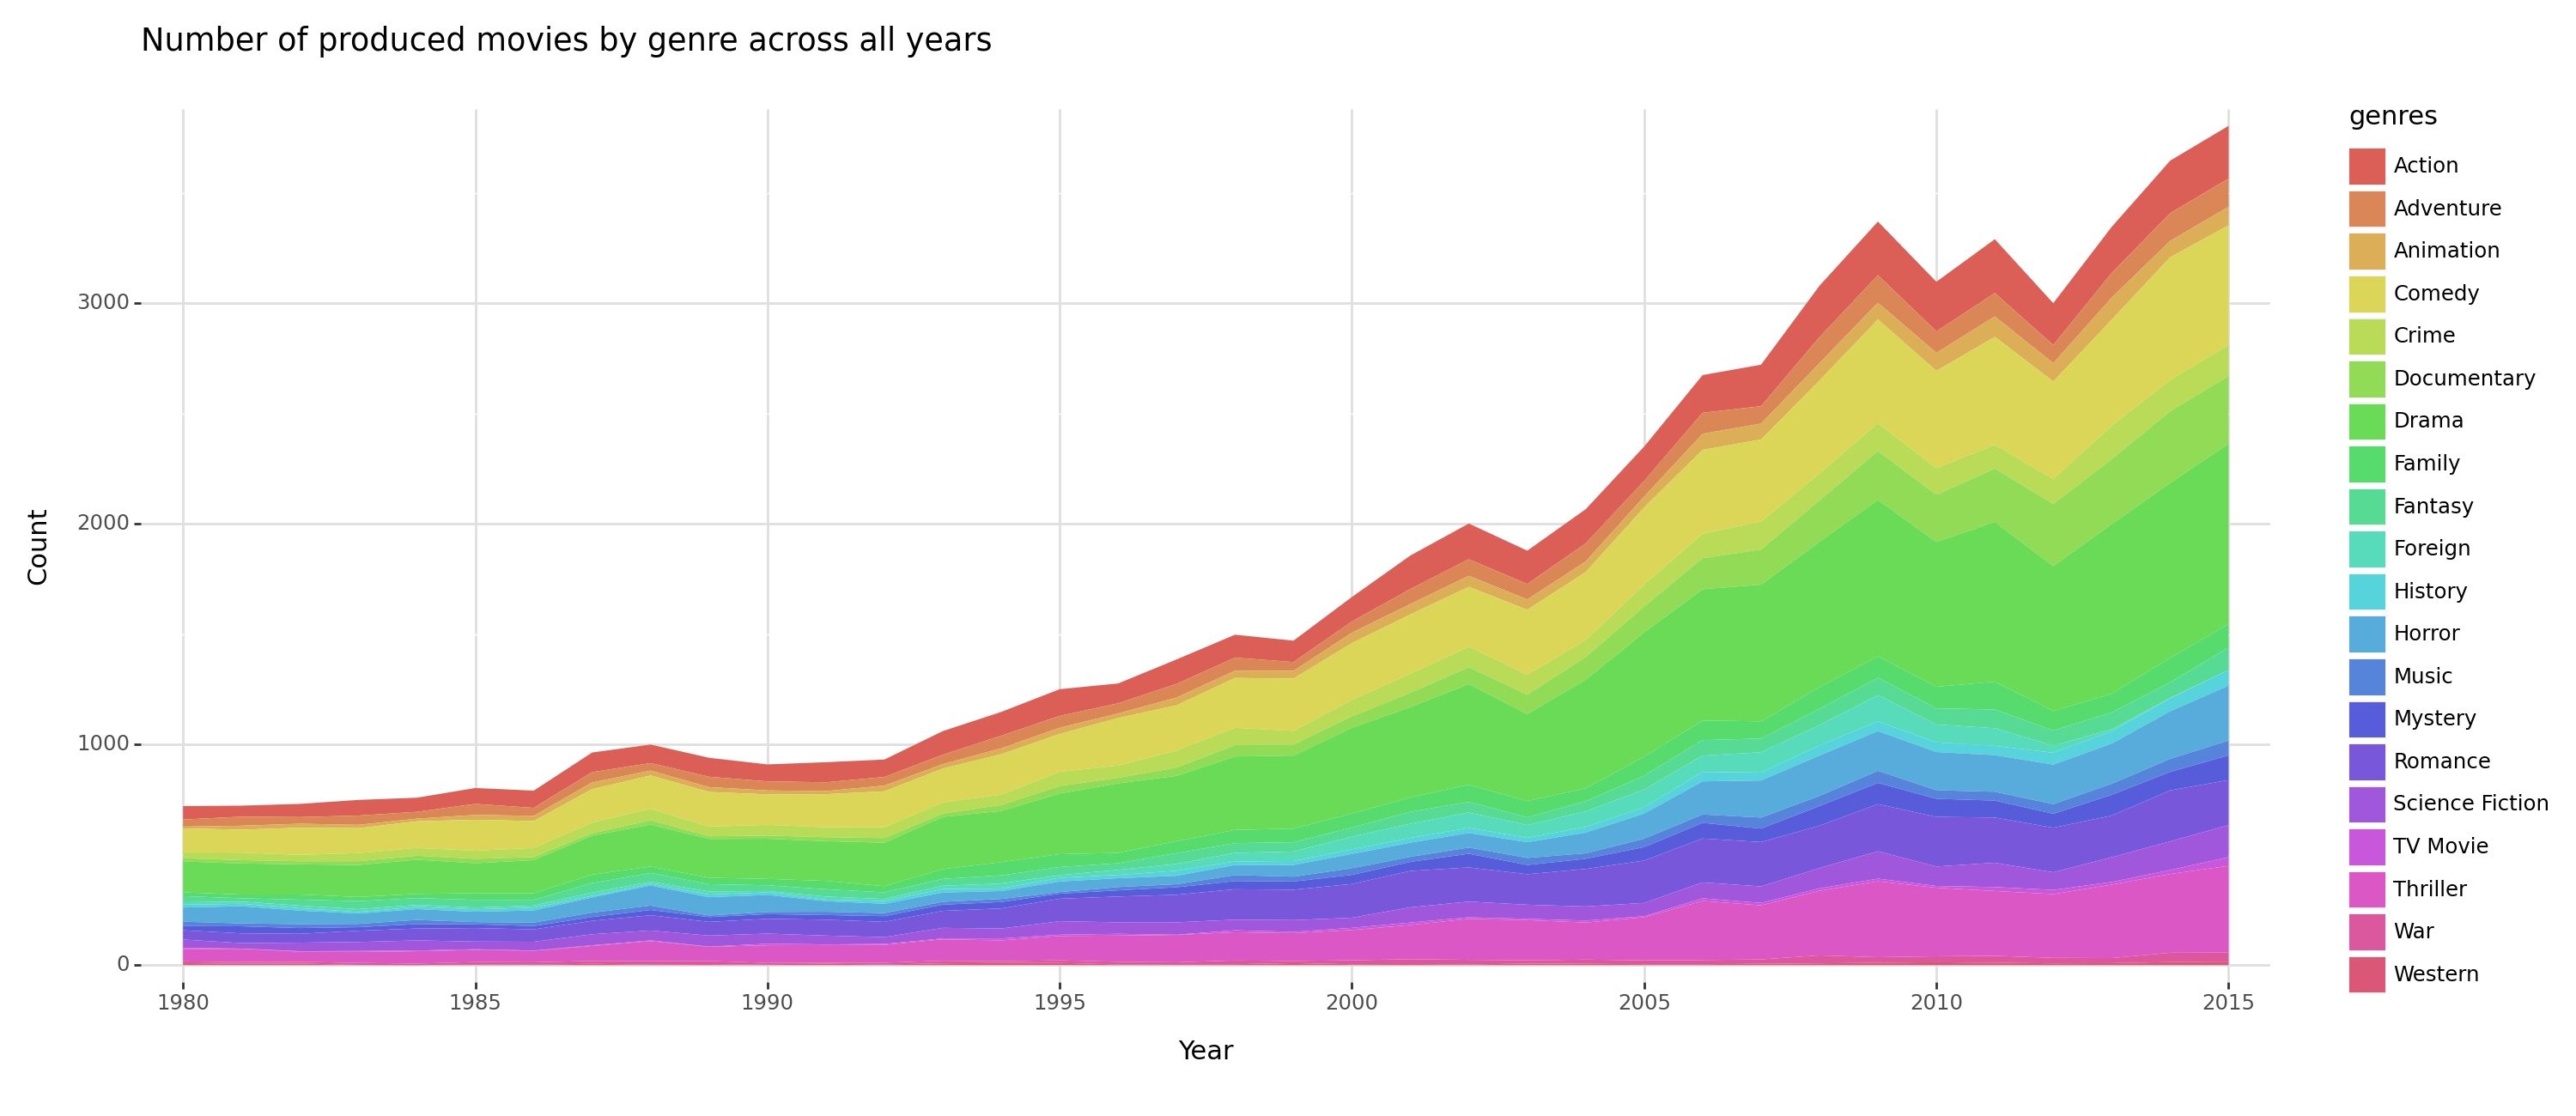

In [28]:
# Total number of produced movies by genre across all years as a stacked area chart.
df_genres_year_count = df_main.explode("genres")
df_genres_year_count = df_genres_year_count.dropna(subset=["genres"])
df_genres_year_count["genres"] = df_genres_year_count["genres"].str.strip()

df_genres_year_count = (
    df_genres_year_count.groupby(["release_year", "genres"])
    .size()
    .reset_index(name="count")
)
df_genres_year_count = df_genres_year_count.sort_values(
    by="release_year", ascending=True
)
df_genres_year_count["count"] = df_genres_year_count["count"].astype(int)

p = (
    p9.ggplot(df_genres_year_count, p9.aes("release_year", "count", fill="genres"))
    + p9.geom_area()
    + p9.labs(
        x="Year", y="Count", title="Number of produced movies by genre across all years"
    )
    + p9.scale_x_continuous(breaks=range(1970, 2016, 5), expand=(0.02, 0.02))
    + p9.scale_y_continuous(breaks=range(0, 15000, 1000), expand=(0.02, 0.02))
    + p9.theme(
        figure_size=(15, 6.5),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)
p.draw()


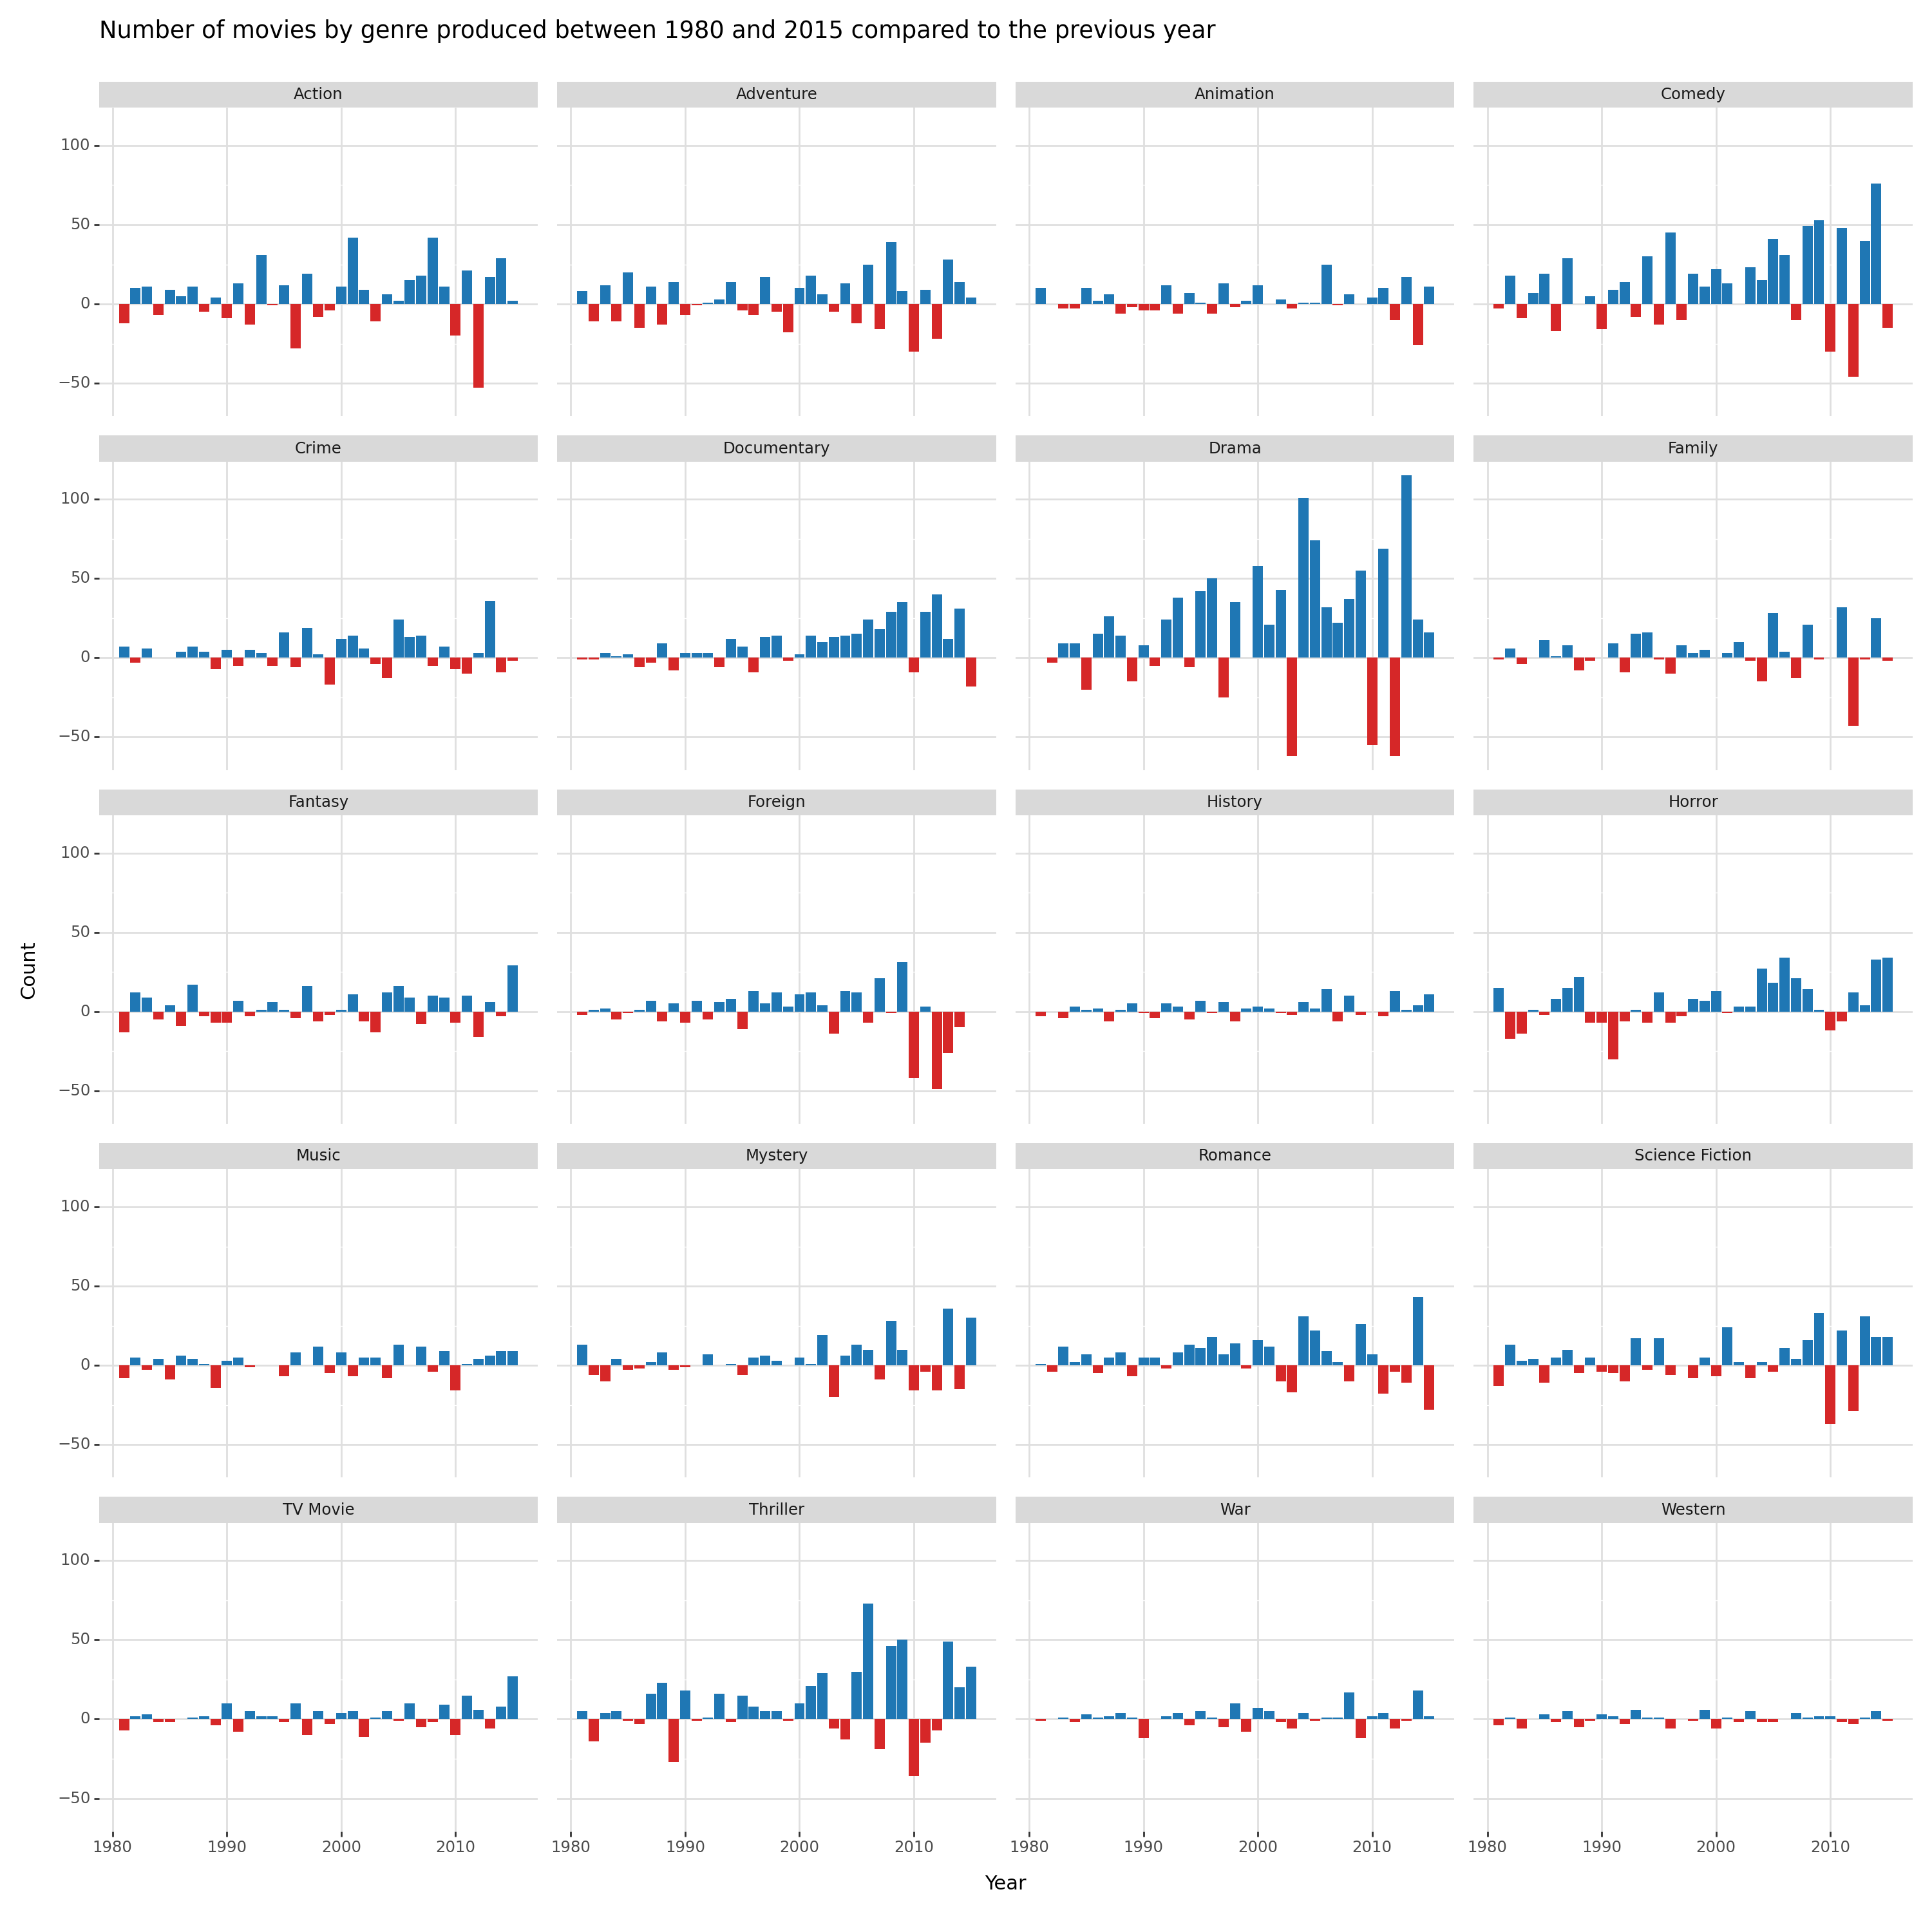

In [15]:
# Let's do a re-expression of the number of movies by genre. We will use the increase per year as a metric.
df_genres = df_main.explode("genres")
df_genres = df_genres.dropna(subset=["genres"])
df_genres["genres"] = df_genres["genres"].str.strip()
df_genres_count = (
    df_genres.groupby(["genres", "release_year"]).size().reset_index(name="count")
)
df_genres_count = df_genres_count.sort_values(
    by=["genres", "release_year"], ascending=True
)
df_genres_count["count"] = df_genres_count["count"].astype(int)

df_genres_count["count"] = df_genres_count.groupby("genres")["count"].diff()
df_genres_count = df_genres_count.dropna(subset=["count"])
df_genres_count["count"] = df_genres_count["count"].astype(int)

p = (
    p9.ggplot(df_genres_count, p9.aes("release_year", "count"))
    + p9.geom_bar(stat="identity", fill="#1f77b4")
    + p9.geom_bar(
        data=df_genres_count[df_genres_count["count"] < 0],
        stat="identity",
        fill="#d62728",
    )
    + p9.labs(
        x="Year",
        y="Count",
        title="Number of movies by genre produced between 1980 and 2015 compared to the previous year",
    )
    + p9.scale_x_continuous(breaks=range(1970, 2016, 10))
    + p9.facet_wrap("genres", ncol=4, scales="fixed", labeller="label_context")
    + p9.theme(
        figure_size=(15, 15),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)
p.draw()


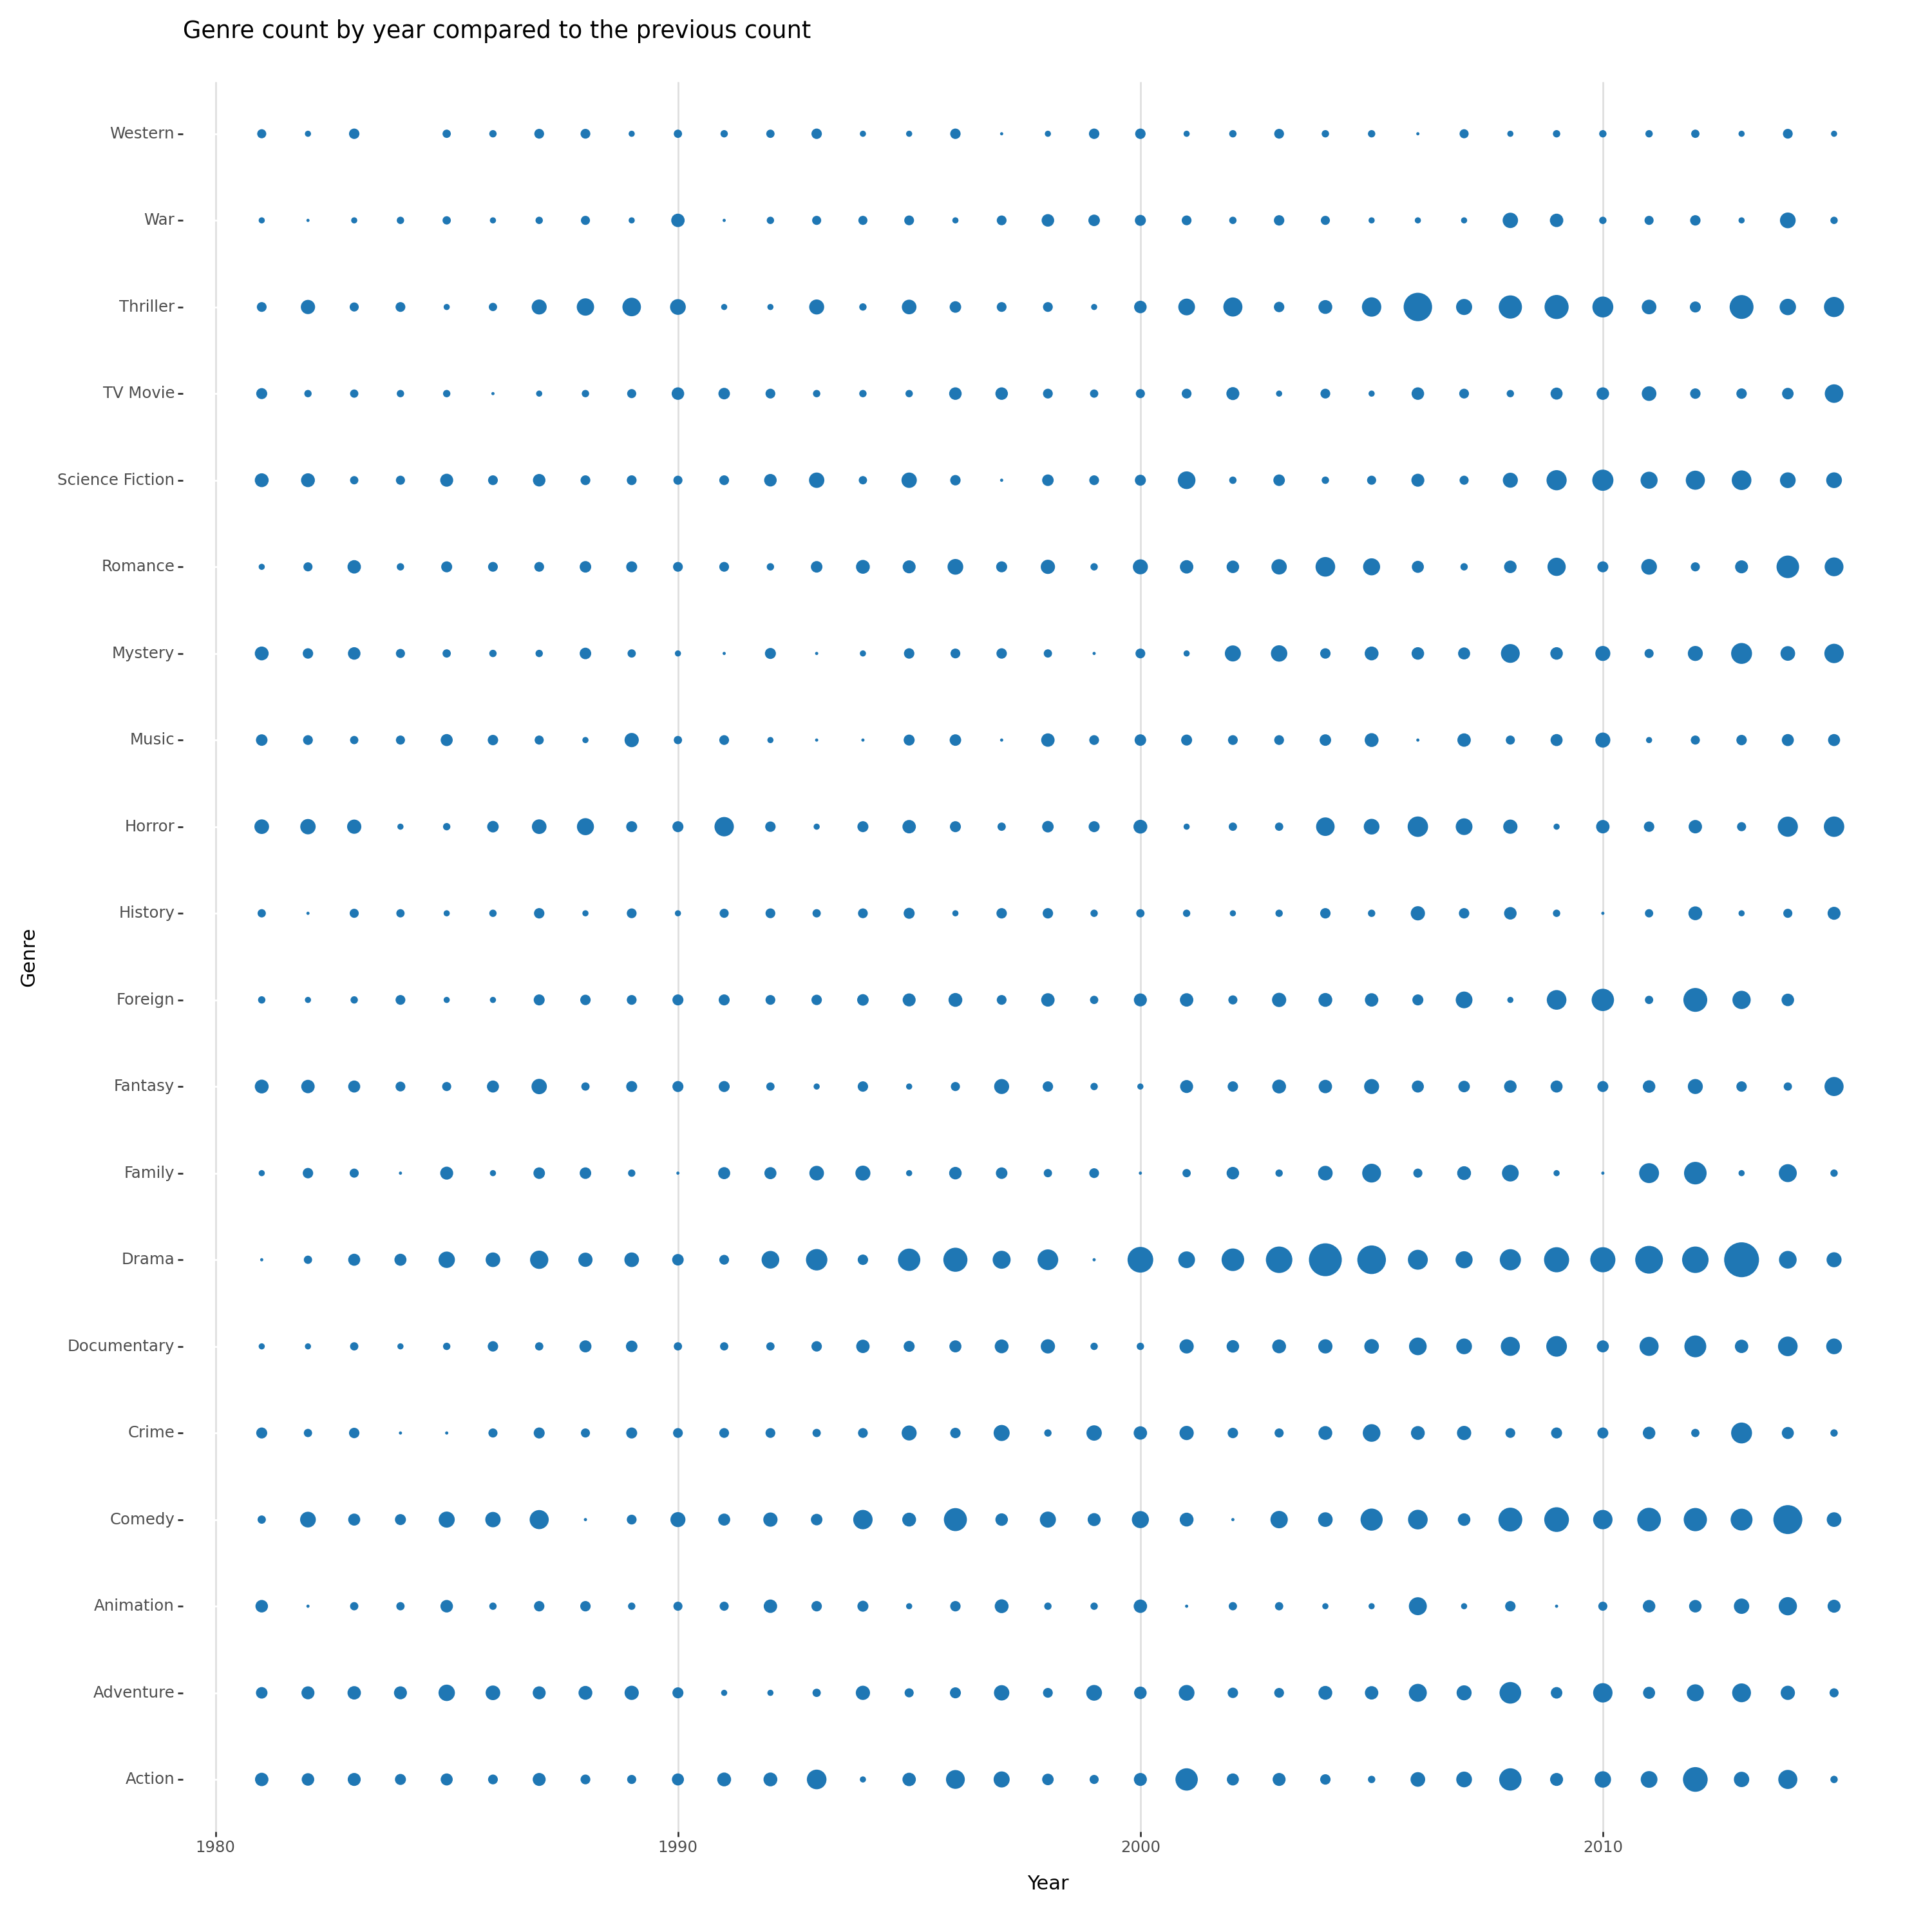

In [16]:
# Genre count by year re-expression

df_genres = df_main.explode("genres")
df_genres = df_genres.dropna(subset=["genres"])
df_genres["genres"] = df_genres["genres"].str.strip()
df_genres_count = (
    df_genres.groupby(["genres", "release_year"]).size().reset_index(name="count")
)
df_genres_count = df_genres_count.sort_values(
    by=["genres", "release_year"], ascending=True
)
df_genres_count["count"] = df_genres_count["count"].astype(int)

df_genres_count["count"] = df_genres_count.groupby("genres")["count"].diff()
df_genres_count = df_genres_count.dropna(subset=["count"])
df_genres_count["count"] = df_genres_count["count"].astype(int)

df_genres_count["count"] = df_genres_count["count"].abs()
df_genres_count["count"] = df_genres_count["count"] / df_genres_count["count"].max()
df_genres_count["count"] = df_genres_count["count"] * 100

p = (
    p9.ggplot(df_genres_count, p9.aes("release_year", "genres", size="count"))
    + p9.geom_point(fill="#1f77b4", color="#1f77b4")
    + p9.labs(
        x="Year", y="Genre", title="Genre count by year compared to the previous count"
    )
    + p9.scale_x_continuous(breaks=range(1970, 2016, 10))
    + p9.scale_size_continuous(range=(0, 10))
    + p9.theme(
        figure_size=(15, 15),
        legend_position="none",
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major_x=p9.element_line(color="#dfdfdf", size=1),
    )
)
p.draw()


/Users/oliver/ZHAW/subjects/infviz/infvis-poster/venv/lib/python3.11/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_fill_cmap could not recognise parameter `low`
/Users/oliver/ZHAW/subjects/infviz/infvis-poster/venv/lib/python3.11/site-packages/plotnine/scales/scale.py:143: PlotnineWarning: scale_fill_cmap could not recognise parameter `high`


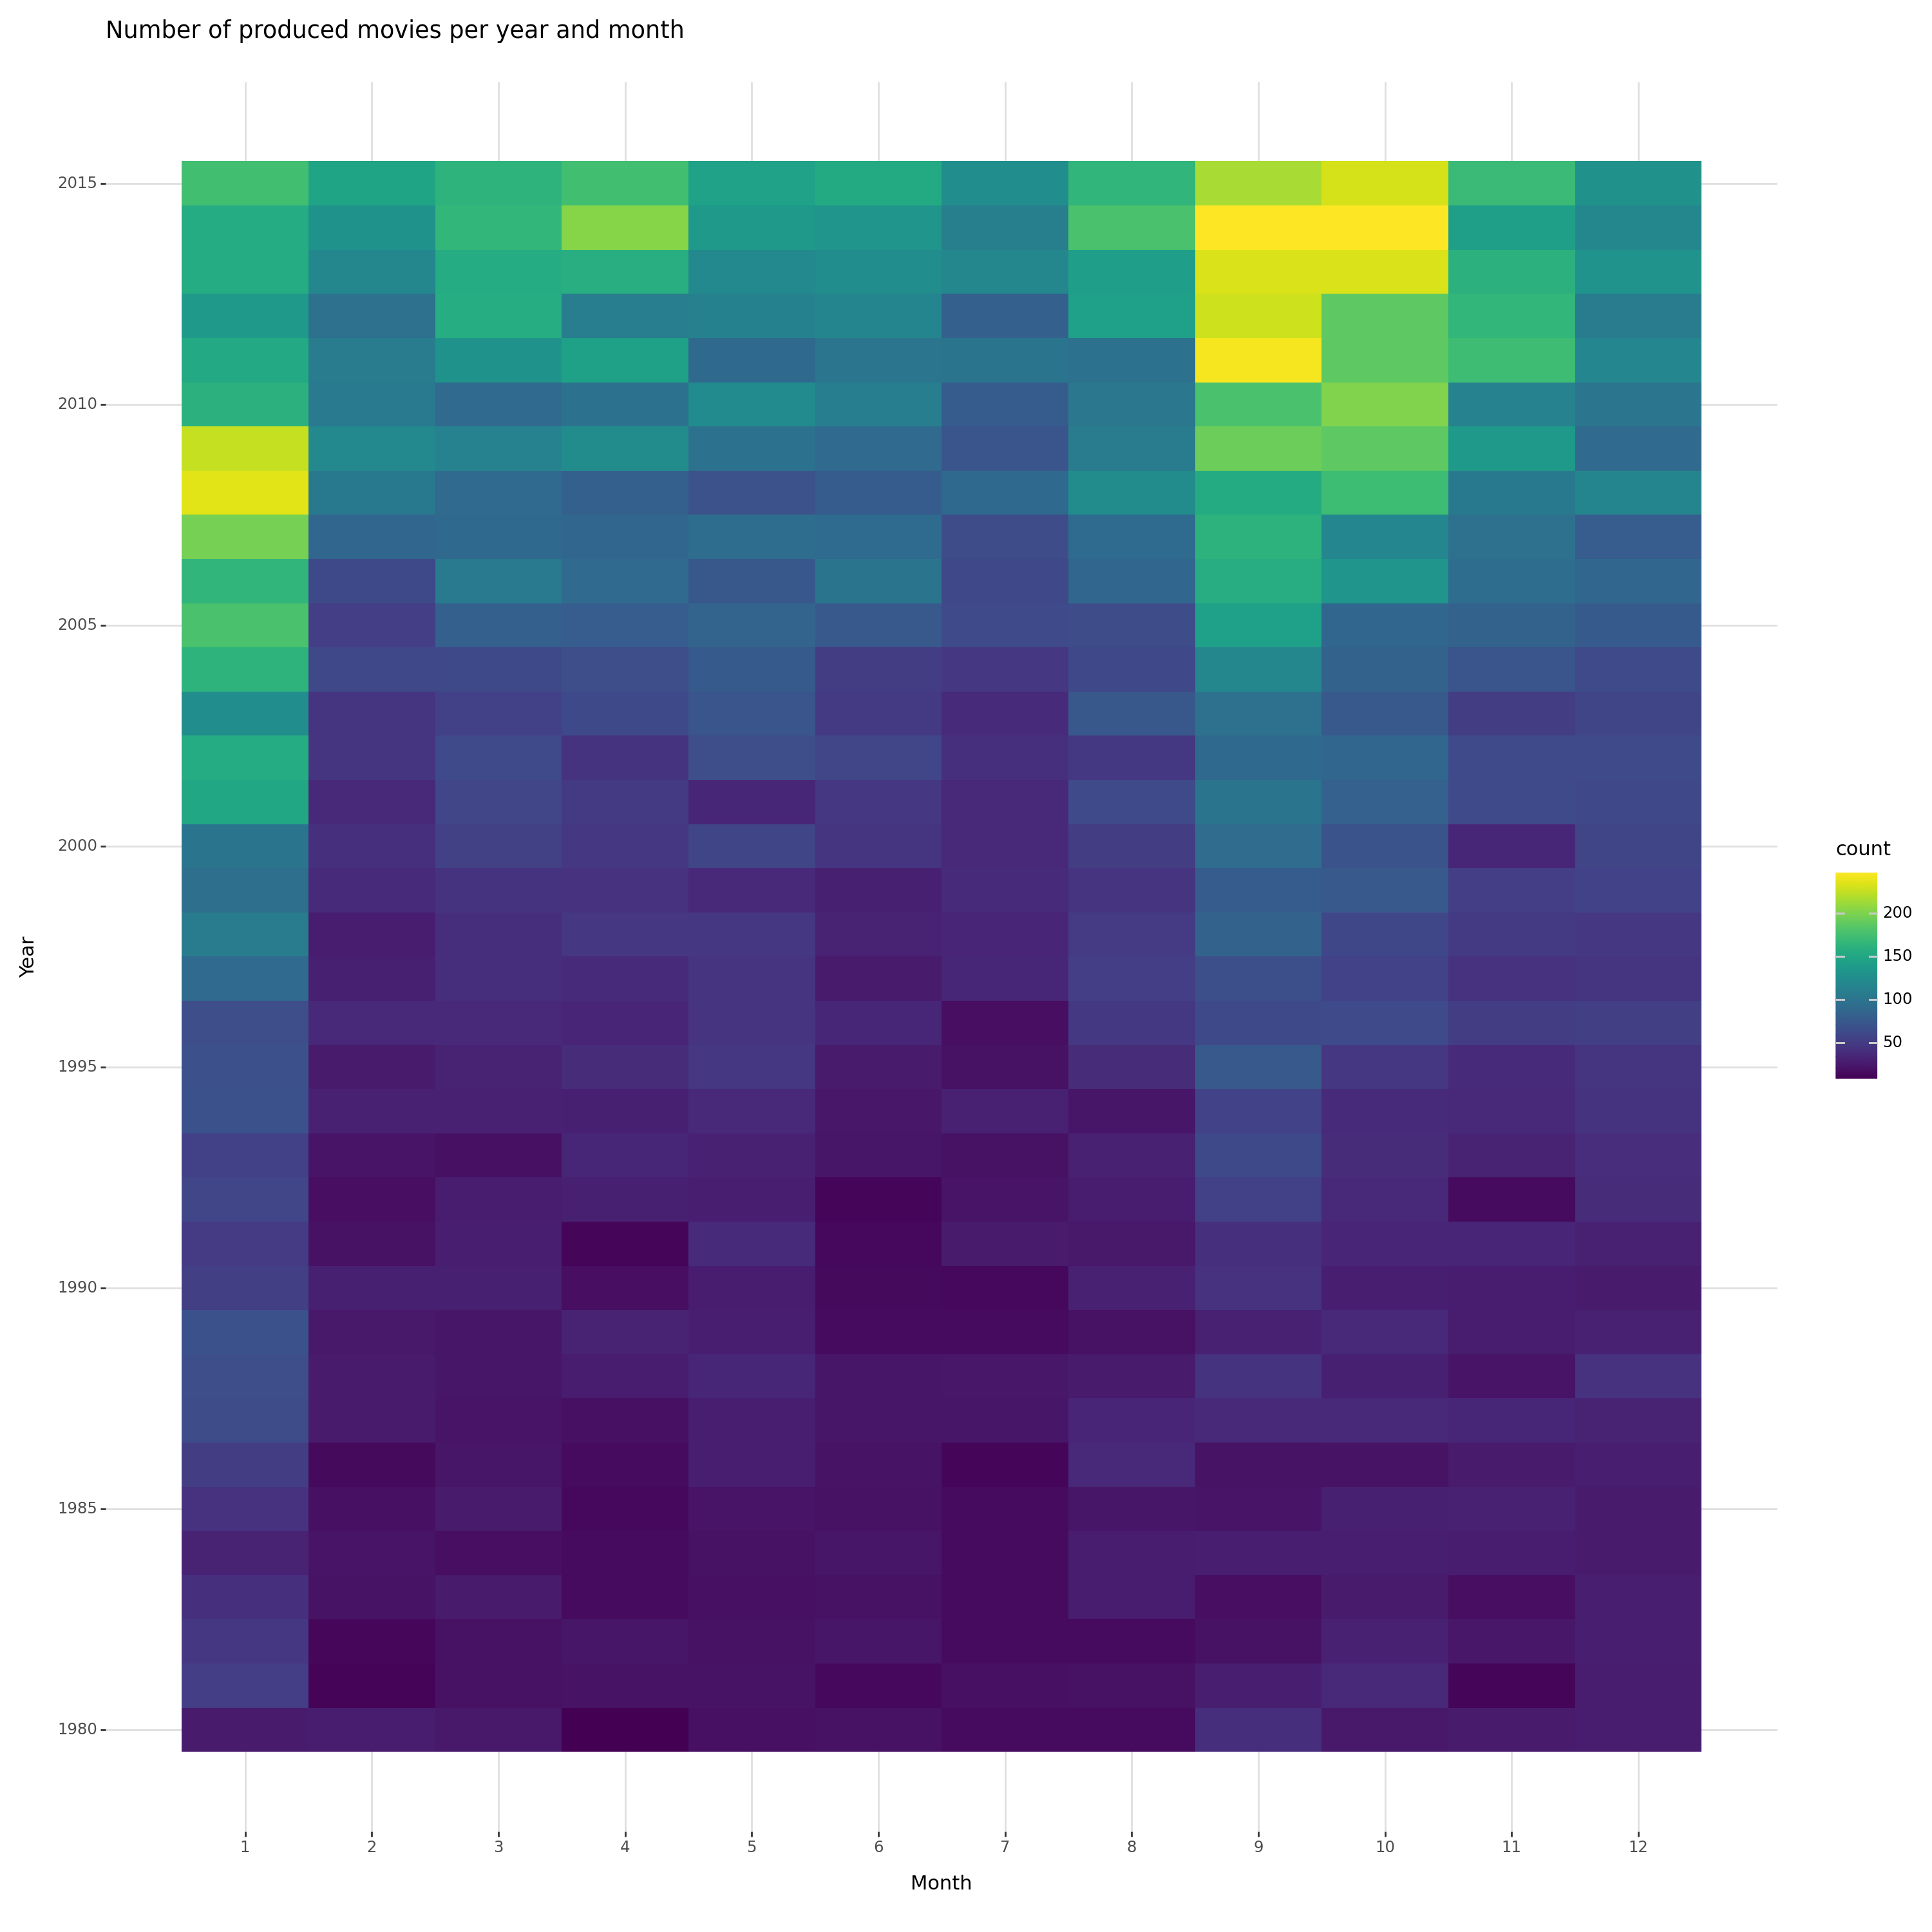

In [17]:
# Number of produced movies per year and month as tiles.
df_year_month_count = (
    df_main.groupby(["release_year", "release_month"]).size().reset_index(name="count")
)
df_year_month_count = df_year_month_count.sort_values(
    by=["release_year", "release_month"], ascending=True
)
df_year_month_count["count"] = df_year_month_count["count"].astype(int)

p = (
    p9.ggplot(
        df_year_month_count, p9.aes("release_month", "release_year", fill="count")
    )
    + p9.geom_tile()
    + p9.labs(x="Month", y="Year", title="Number of produced movies per year and month")
    + p9.scale_fill_continuous(low="#ffffff", high="#1f77b4")
    + p9.scale_x_continuous(breaks=range(1, 13))
    + p9.scale_y_continuous(breaks=range(1970, 2016, 5))
    + p9.theme(
        figure_size=(15, 15),
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)
p.draw()


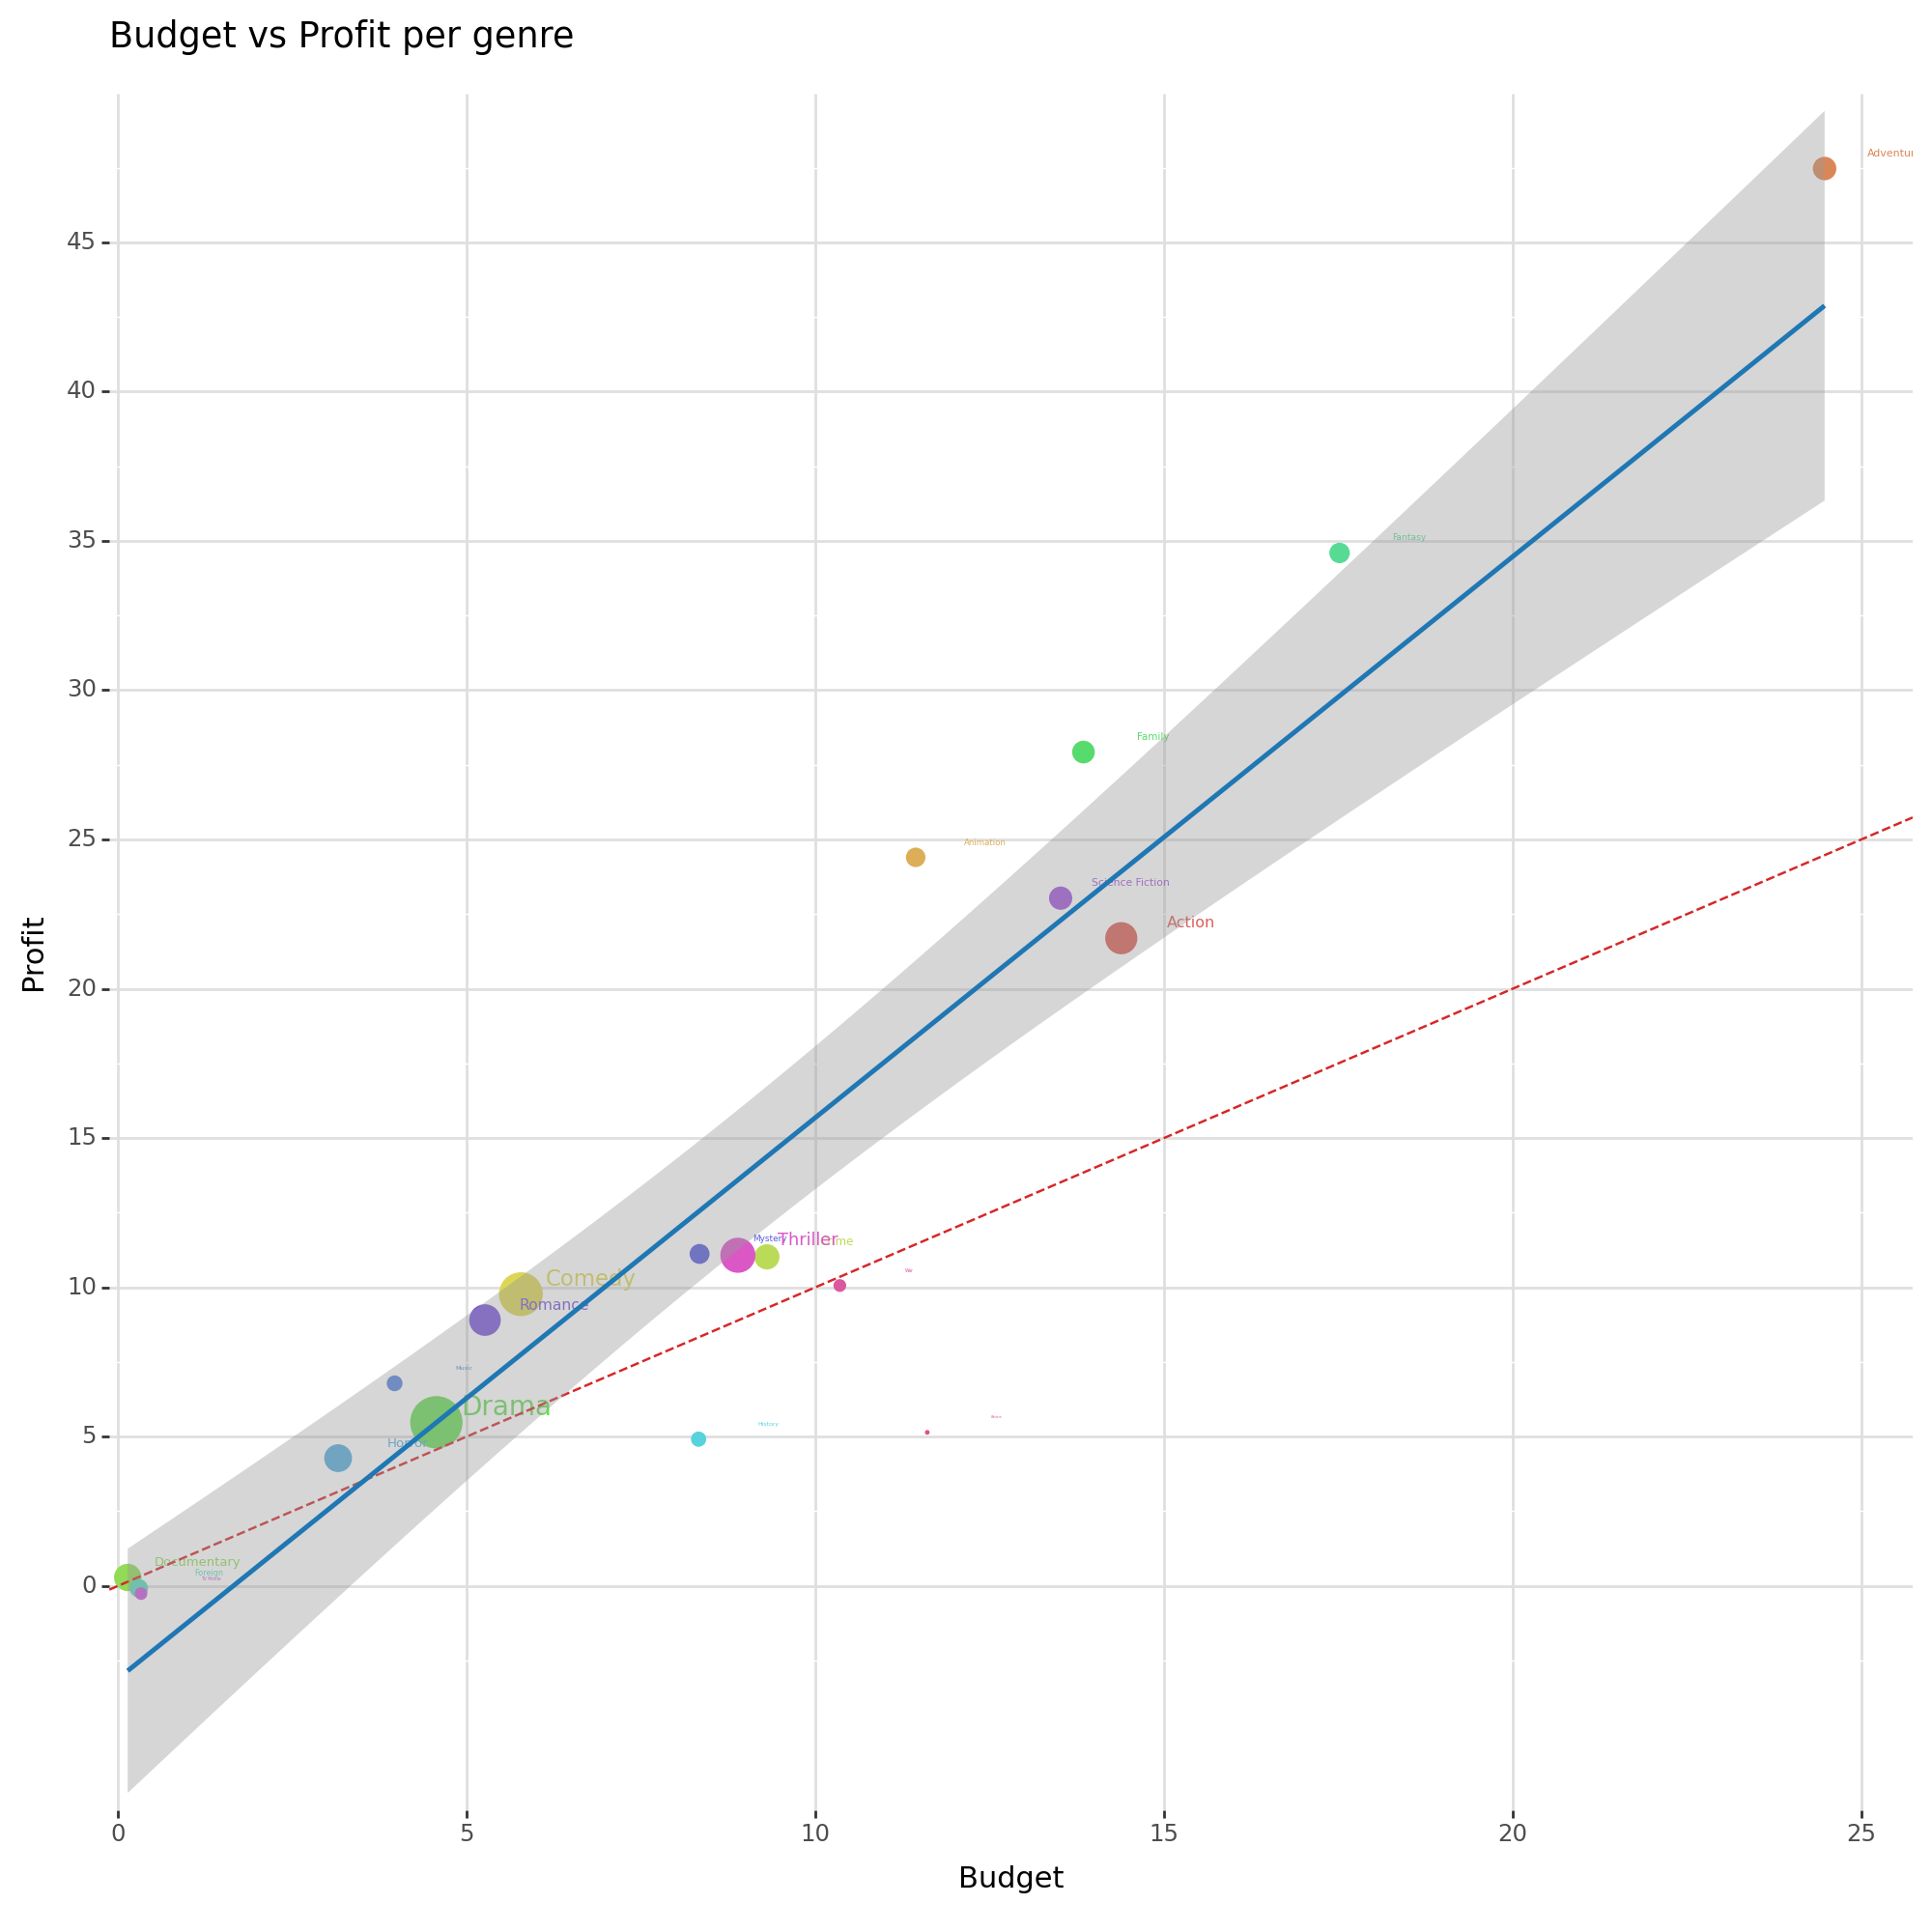

In [11]:
# For each genre we need to calculate the average budget, revenue and how many movies were produced.
# In the plot, the x-axis will be the budget, the y axis the profit, the size of the bubble will be the number of movies produced and the color will be the genre.
df_genres = df_main.explode("genres")
df_genres = df_genres.dropna(subset=["genres"])
df_genres["genres"] = df_genres["genres"].str.strip()

df_genres = (
    df_genres.groupby("genres")
    .agg(
        {
            "budget": "mean",
            "revenue": "mean",
            "id": "count",
        }
    )
    .reset_index()
)

df_genres["profit"] = df_genres["revenue"] - df_genres["budget"]
df_genres["budget"] = df_genres["budget"] / 1000000
df_genres["revenue"] = df_genres["revenue"] / 1000000
df_genres["profit"] = df_genres["profit"] / 1000000

p = (
    p9.ggplot(df_genres, p9.aes("budget", "profit", size="id", color="genres"))
    + p9.geom_point()
    + p9.labs(x="Budget", y="Profit", title="Budget vs Profit per genre")
    + p9.scale_x_continuous(breaks=range(0, 55, 5), expand=(0.01, 0.01))
    + p9.scale_y_continuous(breaks=range(0, 55, 5), expand=(0.01, 0.01))
    + p9.scale_size_continuous(range=(0, 10))
    + p9.geom_text(p9.aes(label="genres"), nudge_x=1, nudge_y=0.5)
    + p9.geom_abline(
        intercept=0, slope=1, linetype="dashed", color="#d62728", show_legend=True
    )
    + p9.geom_smooth(
        method="lm", color="#1f77b4", se=True, show_legend=True, fullrange=True
    )
    + p9.guides(size=False, color=False)
    + p9.theme(
        figure_size=(10, 10),
        legend_position="",
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)
p.draw()


    main_genre     budget    revenue    id     profit
0       Action   9.654188  22.079317  5909  12.425129
1    Adventure  21.109447  61.141543  1525  40.032096
2    Animation   8.232910  26.618611  1617  18.385701
3       Comedy   4.143706  11.220929  7080   7.077224
4  Documentary   0.696696   1.455007  3279   0.758312
5        Drama   3.494809   7.512822  8442   4.018013
6       Horror   4.235022  12.534241  2430   8.299219


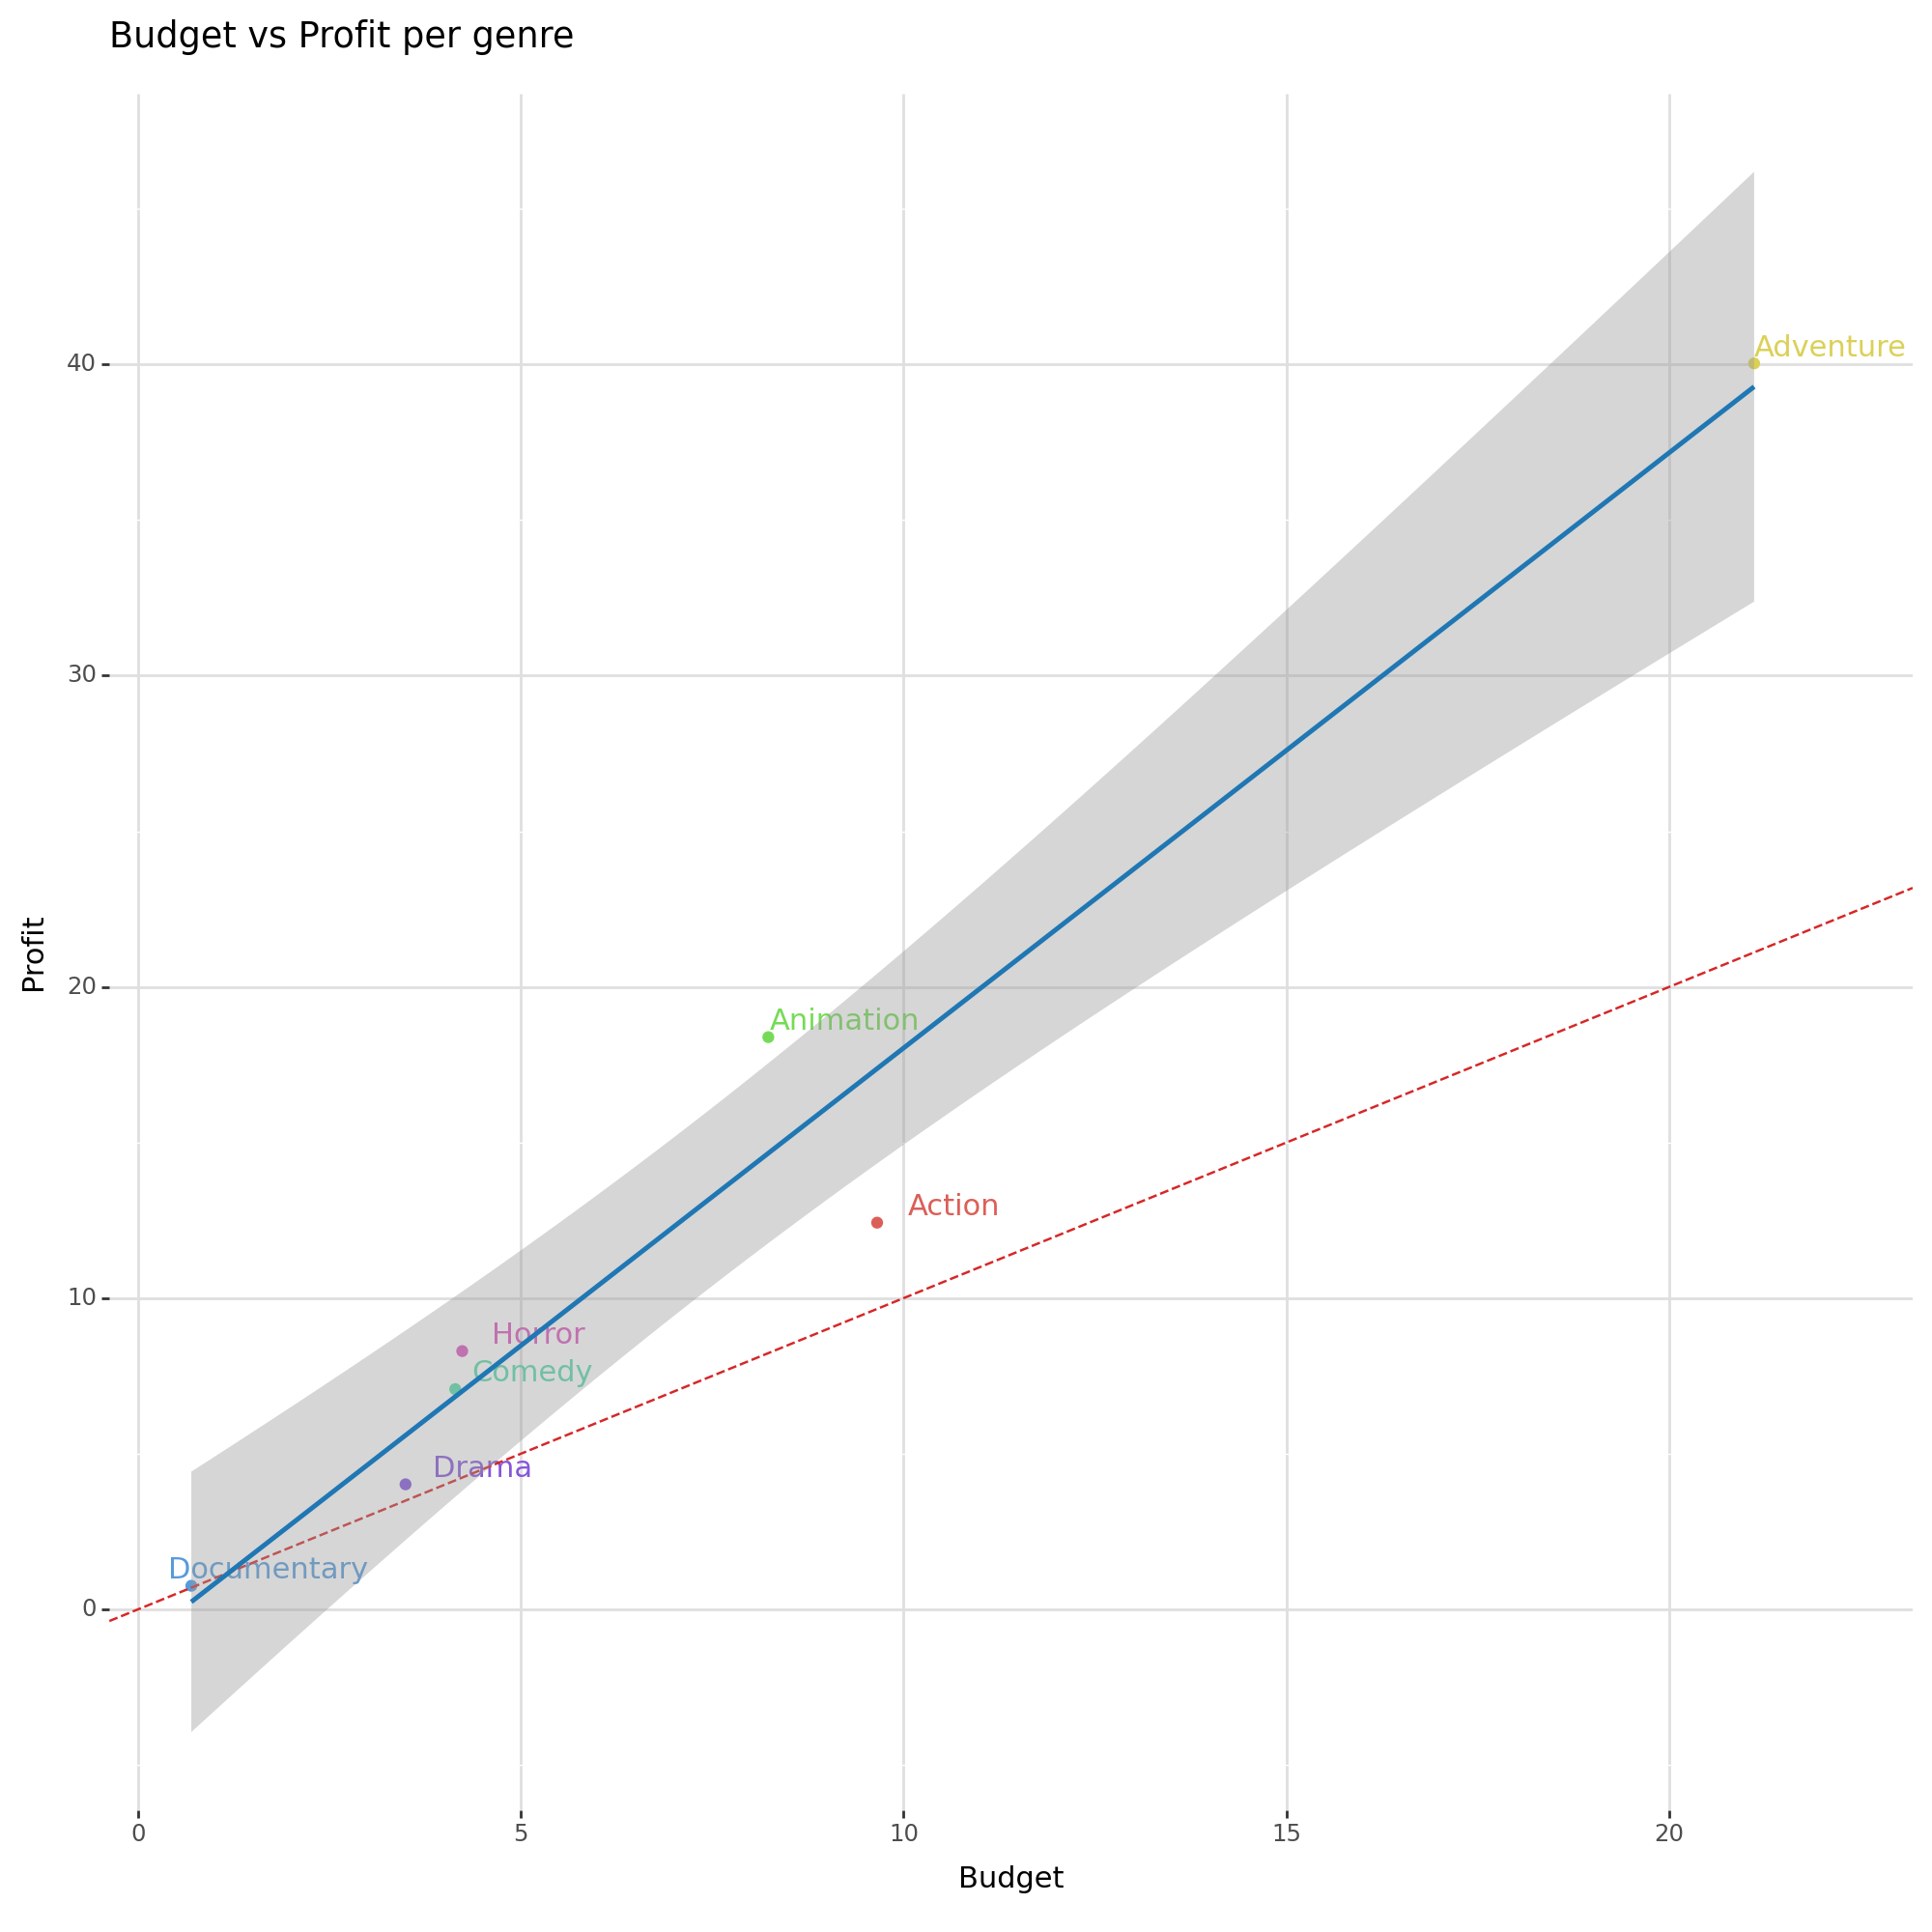

In [12]:
df_genres = (
    df_main.groupby("main_genre")
    .agg(
        {
            "budget": "mean",
            "revenue": "mean",
            "id": "count",
        }
    )
    .reset_index()
)

df_genres["profit"] = df_genres["revenue"] - df_genres["budget"]
df_genres["budget"] = df_genres["budget"] / 1000000
df_genres["revenue"] = df_genres["revenue"] / 1000000
df_genres["profit"] = df_genres["profit"] / 1000000

print(df_genres)

p = (
    p9.ggplot(df_genres, p9.aes("budget", "profit", color="main_genre"))
    + p9.geom_point()
    + p9.labs(x="Budget", y="Profit", title="Budget vs Profit per genre")
    # + p9.scale_x_continuous(breaks=range(0, 55, 5), expand=(0.01, 0.01))
    # + p9.scale_y_continuous(breaks=range(0, 55, 5), expand=(0.01, 0.01))
    + p9.scale_size_continuous(range=(0, 10))
    + p9.geom_text(p9.aes(label="main_genre"), nudge_x=1, nudge_y=0.5)
    + p9.geom_abline(
        intercept=0, slope=1, linetype="dashed", color="#d62728", show_legend=True
    )
    + p9.geom_smooth(
        method="lm", color="#1f77b4", se=True, show_legend=True, fullrange=True
    )
    + p9.guides(size=False, color=False)
    + p9.theme(
        figure_size=(10, 10),
        legend_position="",
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
    )
)
p.draw()


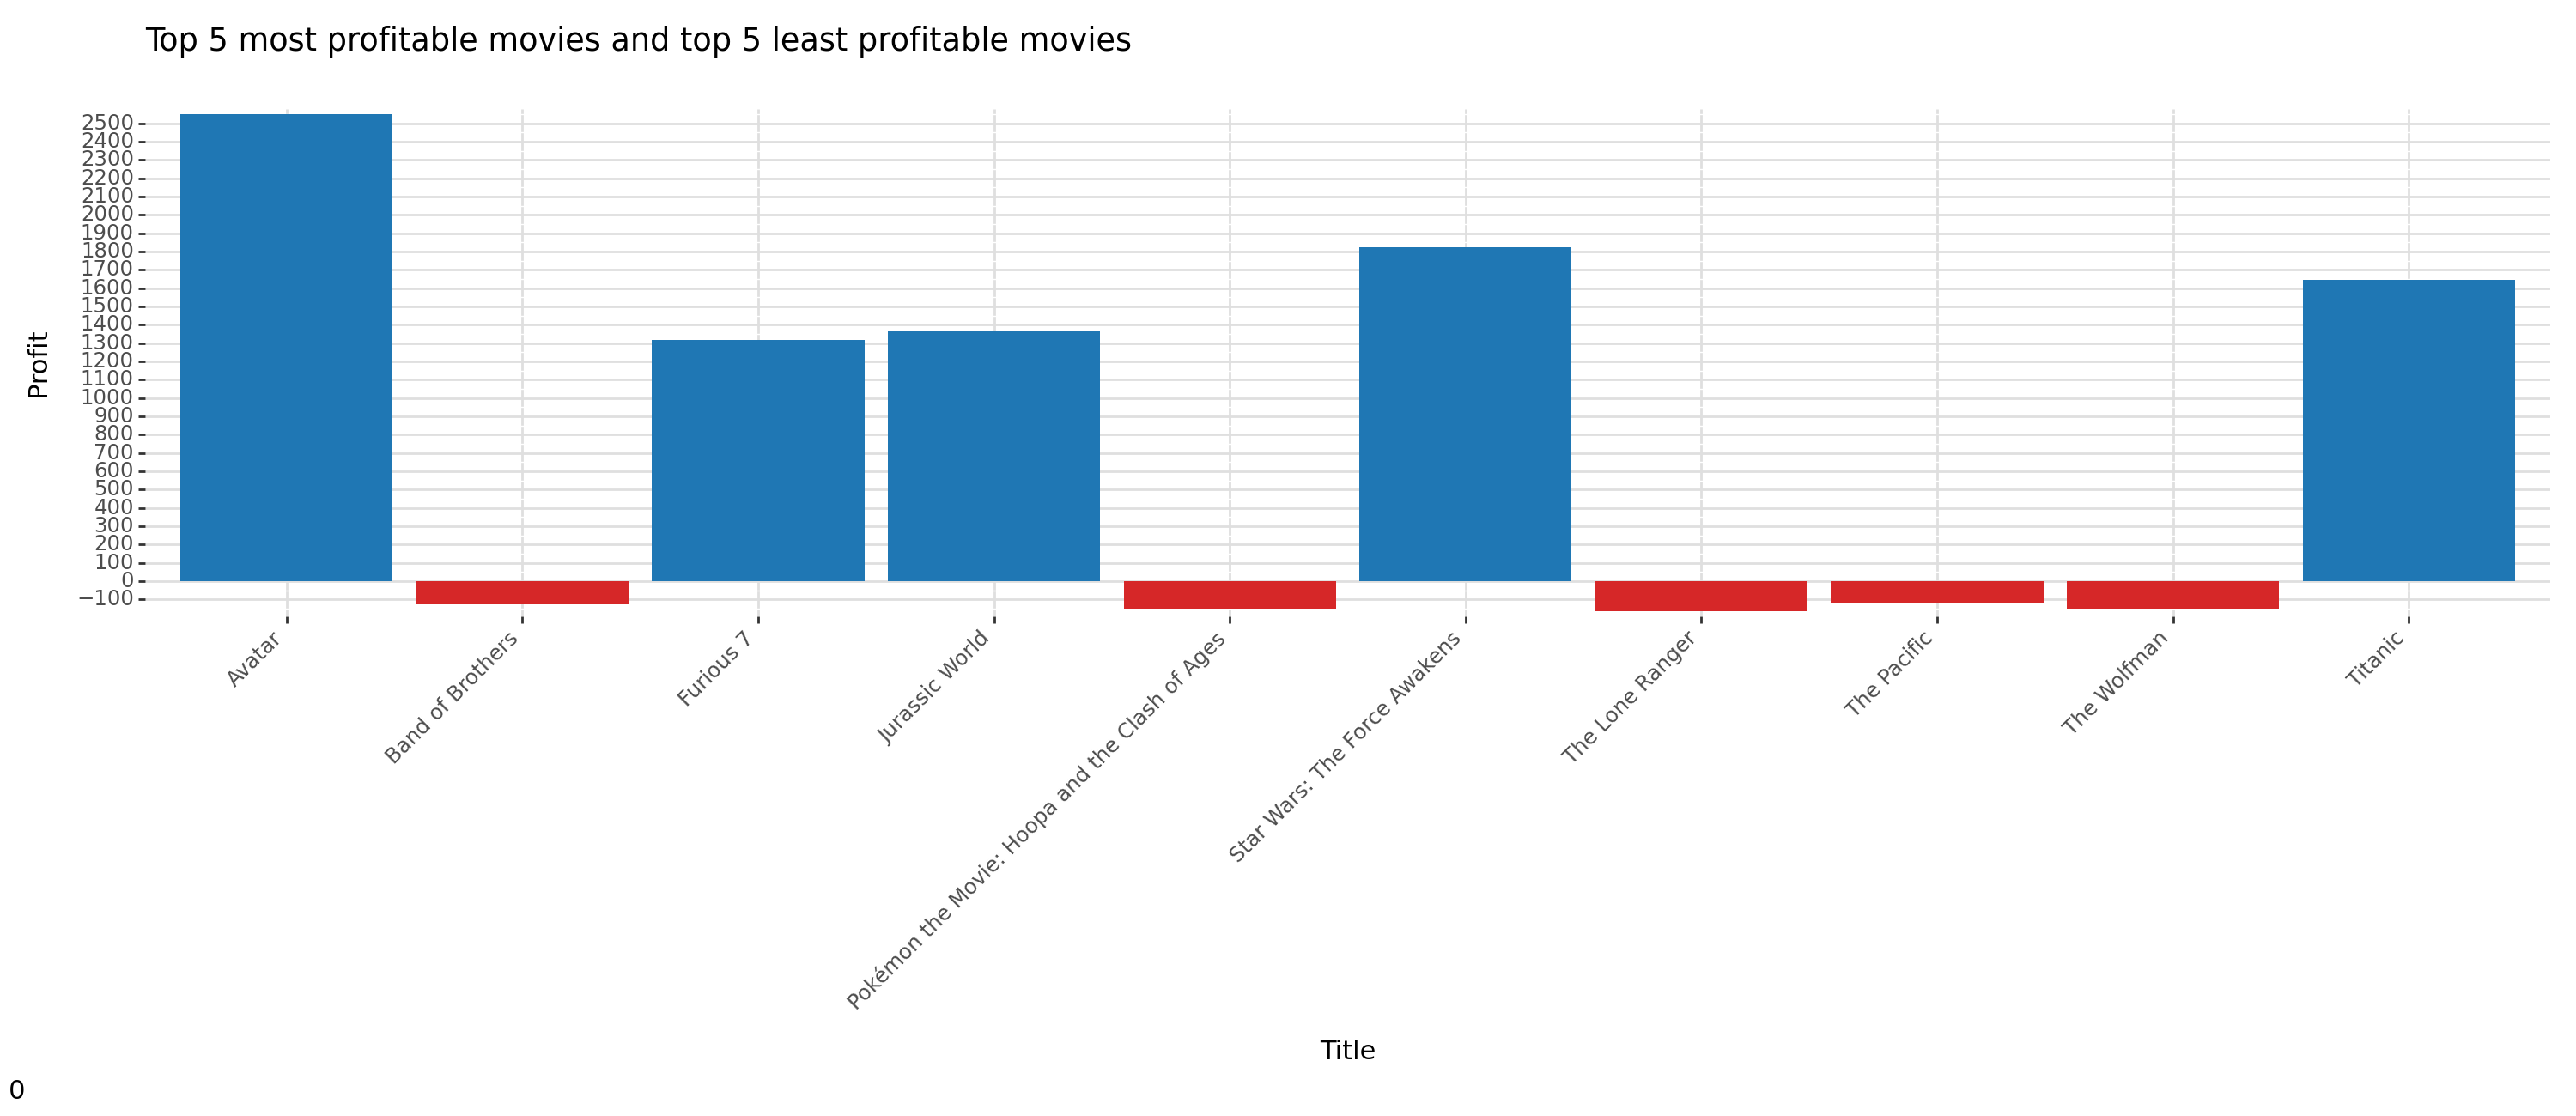

In [20]:
# Top 5 most profitable movies and top 5 least profitable movies in a single table.
df_profitable = df_main.copy()
# Round revenue and budget to nearest million
df_profitable["revenue"] = df_profitable["revenue"] / 1000000
df_profitable["revenue"] = df_profitable["revenue"].round()
df_profitable["budget"] = df_profitable["budget"] / 1000000
df_profitable["budget"] = df_profitable["budget"].round()
df_profitable["profit"] = df_profitable["revenue"] - df_profitable["budget"]
df_profitable = df_profitable.sort_values(by="profit", ascending=False)
df_most_profitable = df_profitable[["title", "release_year", "genres", "budget", "revenue", "profit"]].head(5)
df_least_profitable = df_profitable[["title", "release_year", "genres", "budget", "revenue", "profit"]].tail(5)
df_top_and_bottom = pd.concat([df_most_profitable, df_least_profitable])


# Plot the top 5 most profitable movies and top 5 least profitable movies in a single plot.
# Color the bars blue if the movie is profitable and red if it is not.
# Show the title of the movie on the x-axis and the profit on the y-axis.
# The y-axis should have 10m increments.

p = (
    p9.ggplot(df_top_and_bottom, p9.aes("title", "profit", fill="profit > 0"))
    + p9.geom_col()
    + p9.labs(x="Title", y="Profit", title="Top 5 most profitable movies and top 5 least profitable movies")
    + p9.scale_y_continuous(breaks=range(-1000, 3000, 100), expand=(0.01, 0.01))
    + p9.scale_fill_manual(values=["#d62728", "#1f77b4"])
    + p9.theme(
        figure_size=(15, 6.5),
        legend_position="",
        panel_background=p9.element_rect(fill="white"),
        panel_grid_major=p9.element_line(color="#dfdfdf", size=1),
        # tilt the x-axis labels
        axis_text_x=p9.element_text(rotation=45, hjust=1),
    )
)
p.draw()
